In [1]:
# Intorduction:
#   This repository contains a Python-based simulation framework for evaluating the effects of coefficient and output quantization on IIR filters. 
#   It compares floating-point and fixed-point implementations, providing insights into quantization-induced errors through both theoretical analysis and empirical simulation.
# Author:
#   Siqi Hui
# Version history:
#   1.0.0: initial version with basic functionality, including: 
#     - IIR filter design and implementation
#     - quantization of filter coefficients and outputs
#     - simulation of quantization errors
#   1.0.1: added support for highpass filters
#   1.0.2: added noise level parameter to simulate real-world conditions    
#   1.0.3: added simulation for mean quantization errors in different frequency bands
#   1.0.4: modify iir's ouput to be quantized by np.floor(y)+1, which is more suitable for fixed-point implementation
#   1.0.5: add software-base optimized method
#   1.0.6: use c-fixed lpf model to replace the previous iir filter design

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy.signal as signal
import cffi
import os


In [3]:
# quant iir
# fast implementation of quantized IIR filter
# class QuantizedIIRFilter:
#     def __init__(self, b0, b1, b2, a1, a2, iir_coeff_bit, output_dec_bits=1, feedback_half_lsb=False):
#         # 系数量化
#         coeff_quant_factor = 1/(2**iir_coeff_bit)
#         self.b0 = np.round(b0 / coeff_quant_factor) * coeff_quant_factor
#         self.b1 = np.round(b1 / coeff_quant_factor) * coeff_quant_factor
#         self.b2 = np.round(b2 / coeff_quant_factor) * coeff_quant_factor
#         self.a1 = np.round(a1 / coeff_quant_factor) * coeff_quant_factor
#         self.a2 = np.round(a2 / coeff_quant_factor) * coeff_quant_factor
#         self.feedback_half_lsb = feedback_half_lsb

#         # 初始化存储过去的值, y1 y2为高bit的值
#         self.x1 = 0
#         self.x2 = 0
#         self.y1 = 0
#         self.y2 = 0
        
#         # 系数量化银子
#         self.coeff_quant_factor = coeff_quant_factor
#         # 输出量化因子
#         self.output_dec_bits = output_dec_bits
#         self.output_quant_factor = 0.5**output_dec_bits
    
#     def process(self, x):
#         # 计算当前输出
#         y1_q = self.y1 / self.output_quant_factor
#         y2_q = self.y2 / self.output_quant_factor
#         a1_q = self.a1 / self.coeff_quant_factor
#         a2_q = self.a2 / self.coeff_quant_factor

#         # feed back: a1y1 + a2y2, # + 2**(self.output_dec_bits-1)
#         # add extra offset 0.5 lsb to avoid negative feedback
#         if self.feedback_half_lsb:
#             feed_back_requant = np.floor((a1_q * y1_q + a2_q * y2_q + (a1_q + a2_q)/2) * self.output_quant_factor) * self.coeff_quant_factor
#             # print("feed back offset: ", (a1_q/2 + a2_q/2)* self.coeff_quant_factor)
#         else:
#             feed_back_requant = np.floor((a1_q * y1_q + a2_q * y2_q) * self.output_quant_factor) * self.coeff_quant_factor
#         y = self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - feed_back_requant
#         y = np.floor(y / self.output_quant_factor) * self.output_quant_factor

        
#         # 更新历史值
#         self.x2 = self.x1
#         self.x1 = x
#         self.y2 = self.y1
#         self.y1 = y
#         return np.floor(y) #+ 0.5 # 输出向上取整

In [4]:
# 在python环境下包裹cmodel 
class CModelCFFI:
    def __init__(self, source_code_or_path='./lpf.c'):
        """初始化C模型
        Args:
            source_code_or_path: C源代码字符串或C文件路径
        """
        self.ffi = cffi.FFI()
        
        # 定义C接口
        self.ffi.cdef("""
            void lpf(
                bool rst_n,
                int coeffs_0,
                int coeffs_1, 
                int coeffs_2,
                int coeffs_3,
                int coeffs_4,
                int din_data,
                int* dout_data,
                int* dout_frac
            );
        """)
        
        # 编译C代码
        if os.path.exists(source_code_or_path):
            # 从文件读取
            with open(source_code_or_path, 'r') as f:
                source_code = f.read()
        else:
            # 直接使用源代码字符串
            print("C source code file not found.")
            import sys
            sys.exit()
            source_code = source_code_or_path
        
        # 编译并加载库
        self.lib = self.ffi.verify(source_code)
        
        # 存储系数
        self.coeffs = None

        # 准备输出指针
        self.dout_data = self.ffi.new("int*")
        self.dout_frac = self.ffi.new("int*")
    
    def set_coefficients(self, coeffs):
        """设置滤波器系数
        Args:
            coeffs: 包含5个系数的列表或数组
        """
        if len(coeffs) != 5:
            raise ValueError("滤波器需要5个系数")
        self.coeffs = [int(c) for c in coeffs]
    
    def reset(self, ):
        """重置滤波器状态"""
        if self.coeffs is None:
            raise ValueError("请先设置滤波器系数")
        
        # 调用C函数进行重置
        self.lib.lpf(
            False, self.coeffs[0], self.coeffs[1], self.coeffs[2], 
            self.coeffs[3], self.coeffs[4],
            0,
            self.dout_data,
            self.dout_frac
        )
    
    def process(self, input_sample):
        """处理单个样本
        
        Args:
            input_sample: 输入样本值
            
        Returns:
            int: 输出样本值
        """
        if self.coeffs is None:
            raise ValueError("请先设置滤波器系数")

        # 调用C函数
        self.lib.lpf(
            True, self.coeffs[0], self.coeffs[1], self.coeffs[2], 
            self.coeffs[3], self.coeffs[4],
            int(input_sample),
            self.dout_data,
            self.dout_frac
        )
        
        return self.dout_data[0] #, dout_frac[0]

    def cleanup(self):
        if hasattr(self, 'output_ptr'):
            self.ffi.release(self.output_ptr)  # 显式释放


In [5]:
# float iir
class FloatIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def process(self, x):
        # 计算当前输出
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - 
             self.a1 * self.y1 - self.a2 * self.y2)

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [6]:
def signal_generator(fs, time, signal_range, noise_range, signal_offset, start_freq, end_freq):
    """
    生成一个持续仿真时间的每秒频率递增的正弦波信号。
    参数：
    fs - 每秒采样点数
    time - 仿真时间（秒）
    signal_range - 信号幅度范围
    start_freq - 起始频率(Hz)
    end_freq - 终止频率(Hz)
    
    返回：
    generated_signal - 生成的信号
    """
    num_samples = fs * time  # 总样本数
    t = np.linspace(0, time, num_samples, endpoint=False)  # 时间序列
    generated_signal = np.zeros_like(t)  # 初始化信号数组

    # 逐秒递增频率，生成正弦波信号
    for i in range(time):
        freq = start_freq + i * (end_freq - start_freq) / time
        samples_per_cycle = fs / freq  # 每个周期的样本数
        num_cycles = int(fs // samples_per_cycle)  # 每秒能容纳的完整周期数

        if num_cycles >= 1:
            cycle_samples = int(num_cycles * samples_per_cycle)  # 完整周期的样本数
            t_segment = np.linspace(0, cycle_samples / fs, cycle_samples, endpoint=False)  # 当前段的时间序列
            sine_segment = np.sin(2 * np.pi * freq * t_segment)  # 生成当前频率的正弦波
            generated_signal[i * fs : i * fs + cycle_samples] = np.round(sine_segment * signal_range)  # 插入信号

    # 添加直流偏置
    generated_signal += signal_offset

    # 添加白噪声
    if noise_range > 0:
        noise = np.random.uniform(-noise_range, noise_range, len(generated_signal))
        generated_signal += np.round(noise)
    return generated_signal

In [7]:
def analyze_quantization_error(x, fc_fs_ratio, iir_coeff_bit, output_dec_bits, fs=10000, start_freq = 1, end_freq = 2500,
                               signal_range=10000, btype='low', feedback_half_lsb=False, float_iir_use_quant_coeff=True):
    """
    输入：
        x: 输入信号(1D numpy 数组)
        fc_fs_ratio: 截止频率与采样频率之比(0~0.5)
        iir_coeff_bit: IIR滤波器系数的小数部分的量化位宽
        output_dec_bits: 反馈路径的小数量化位宽
        fs: 采样率(默认10000)
        signal_range: 信号幅度缩放因子(默认10000)
        btype: 滤波器类型('low'表示低通滤波器, 'high'表示高通滤波器)
        feedback_half_lsb: 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈(默认False)
    """
    # 设计滤波器
    fc = fc_fs_ratio * fs
    b, a = butter(2, fc / (fs / 2), btype=btype)

    # cmodel quant_iir
    # -------------------------------------------
    try:
        quant_iir = CModelCFFI("./lpf.c")
        print("C模型加载成功!")
    except FileNotFoundError:
        print("C file not found...")
        # 方法2: 让类自动查找
        import sys
        sys.exit()

    fixed_coefficients = [np.round(b[0]*32768), np.round(b[1]*32768), np.round(b[2]*32768), -np.round(a[1]*32768), np.round(a[2]*32768)]
    fixed_coefficients = [int(np.int32(coef)) for coef in fixed_coefficients]
    quant_iir.set_coefficients(fixed_coefficients)
    quant_iir.reset()
    # -------------------------------------------

    # fast python model quant_iir
    # quant_iir = QuantizedIIRFilter(b[0], b[1], b[2], a[1], a[2], iir_coeff_bit, output_dec_bits, feedback_half_lsb)


    # 这里可以选择是否使用量化系数来初始化浮点IIR
    def quant_coeff(coeff, iir_coeff_bit):
        quant_factor = 1/(2**iir_coeff_bit)
        return np.round(coeff / quant_factor) * quant_factor

    if float_iir_use_quant_coeff:
        b[0] = quant_coeff(b[0], iir_coeff_bit)
        b[1] = quant_coeff(b[1], iir_coeff_bit)
        b[2] = quant_coeff(b[2], iir_coeff_bit)
        a[1] = quant_coeff(a[1], iir_coeff_bit)
        a[2] = quant_coeff(a[2], iir_coeff_bit)
    
    float_iir = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])
    y_float = np.array([float_iir.process(sample) for sample in x])
    
    y_quantized = np.array([quant_iir.process(sample) for sample in x])

    # 计算量化误差
    quant_error = y_quantized - y_float

    # 频率标尺
    total_time = len(x) // fs
    t = np.linspace(0, total_time, len(x), endpoint=False)

    # the same with signal_generator
    freq_ticks = [start_freq + (end_freq - start_freq) * (i / total_time) for i in range(0, total_time + 1, 10)]
    time_ticks = [i for i in range(0, total_time + 1, 10)]

    # === 计算每 fs 点内的平均绝对误差 ===
    quant_error_abs = np.abs(quant_error)
    window_size = fs
    mean_abs_error_per_window = [
        np.mean(quant_error_abs[i:i + window_size])
        for i in range(0, len(quant_error_abs), window_size)
    ]
    window_time = np.arange(len(mean_abs_error_per_window))

    # === 绘图 ===
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    ax1 = axes[0]
    ax1.plot(t, y_quantized, label="y_quantized", color='b')
    ax1.set_xticks(time_ticks)
    ax1.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('y_quantized', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend()
    ax1.set_title("Quantized Output Signal")
    ax1.grid(True)

    ax2 = axes[1]
    ax2.plot(t, quant_error, label="quant_error", color='r')
    ax2.set_xticks(time_ticks)
    ax2.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax2.set_xlabel('Frequency')
    ax2.set_ylabel('Quantization Error', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.legend()
    ax2.set_title("Quantization Error")
    ax2.grid(True)

    ax3 = axes[2]
    ax3.plot(window_time, mean_abs_error_per_window, label="mean_abs_error/fs", color='g')
    ax3.set_xticks(time_ticks)
    ax3.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks], rotation=90)
    ax3.set_xlabel('Frequency')
    ax3.set_ylabel('Mean Absolute Error', color='g')
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.legend()
    ax3.set_title("Mean Absolute Quantization Error per fs window")
    ax3.grid(True)

    plt.suptitle(
        f"Effect of Quantization, fc/fs: {fc_fs_ratio}, feedback bitwidth: {output_dec_bits}, "
        f"Coeffs bitwidth: {iir_coeff_bit}, filter bandtype: {btype}, "
        f"feedback_half_lsb: {feedback_half_lsb}, float_iir_use_quant_coeff: {float_iir_use_quant_coeff}",
        fontsize=14
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [8]:
# 计算给定截止频率比例和系数量化位宽下的滤波器量化误差(系数的量化误差会随频率变化而变化)
def calc_quant_error(fc_fs_ratio, fs=10000, btype='low',
                     b_bit=20, a_bit=19, signal_range=16384, verbose=False):
    """
    计算给定截止频率比例和系数量化位宽下的滤波器量化误差

    参数
    ----
    fc_fs_ratio : float
        截止频率与采样率之比 (fc / fs)
    fs : float, optional
        采样率（默认 10000）
    btype : str, optional
        滤波器类型 ('low', 'high', 'bandpass', 'bandstop')
    b_bit : int, optional
        分子 (b) 量化位宽
    a_bit : int, optional
        分母 (a) 量化位宽
    signal_range : float, optional
        输入信号量程（用于放大误差）

    返回
    ----
    quant_err : float
        最大幅频响应误差对应的量化误差
    """

    # 计算截止频率
    fc = fc_fs_ratio * fs

    # 设计二阶巴特沃斯滤波器
    b, a = signal.butter(2, fc / (fs / 2), btype=btype)

    # 定点量化
    quant_b_scale = 2 ** b_bit
    quant_a_scale = 2 ** a_bit
    b_q = np.round(b * quant_b_scale) / quant_b_scale
    a_q = np.round(a * quant_a_scale) / quant_a_scale

    # 计算频率响应
    w, h = signal.freqz(b, a)
    w_q, h_q = signal.freqz(b_q, a_q)

    # 量化误差（取最大响应差 × 信号幅度）
    quant_err = signal_range * np.max(np.abs(h - h_q))
    # if verbose:
    #     print("quant_err close pole point: ", quant_err)
    return quant_err

In [9]:
# method 0
def search_best_fc_fs(fc_fs_ratio, iir_coeff_bit, search_range=0.05, fs=10000, signal_range=16384):
    """
    输入：
        fc_fs_ratio: 截止频率与采样频率之比(0~0.5)
        iir_coeff_bit: IIR滤波器系数的小数部分的量化位宽
        search_range: 在 fc_fs_ratio 的基础上搜索的范围(1-search_range)*fc_fs_ratio,  (1+search_range) * fc_fs_ratio
        fs: 采样率(默认10000)
    """

    start_fc_fs_ratio = fc_fs_ratio * (1 - search_range)
    end_fc_fs_ratio = fc_fs_ratio * (1 + search_range)
    step = 1e-6
    fc_fs_ratio_list = [start_fc_fs_ratio + i * step for i in range(int(search_range*2*fc_fs_ratio/step))]
    fc_fs_ratio_dict = {} # fc_fs_ratio -> delta_error

    for fc_fs_ratio in fc_fs_ratio_list:
        fc_fs_ratio_dict[fc_fs_ratio] = calc_quant_error(fc_fs_ratio, fs=fs, btype='low', b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=False)
    
    best_fc_fs_ratio = min(fc_fs_ratio_dict, key=fc_fs_ratio_dict.get)

    return best_fc_fs_ratio

original fc_fs_ratio:  0.004
C模型加载成功!


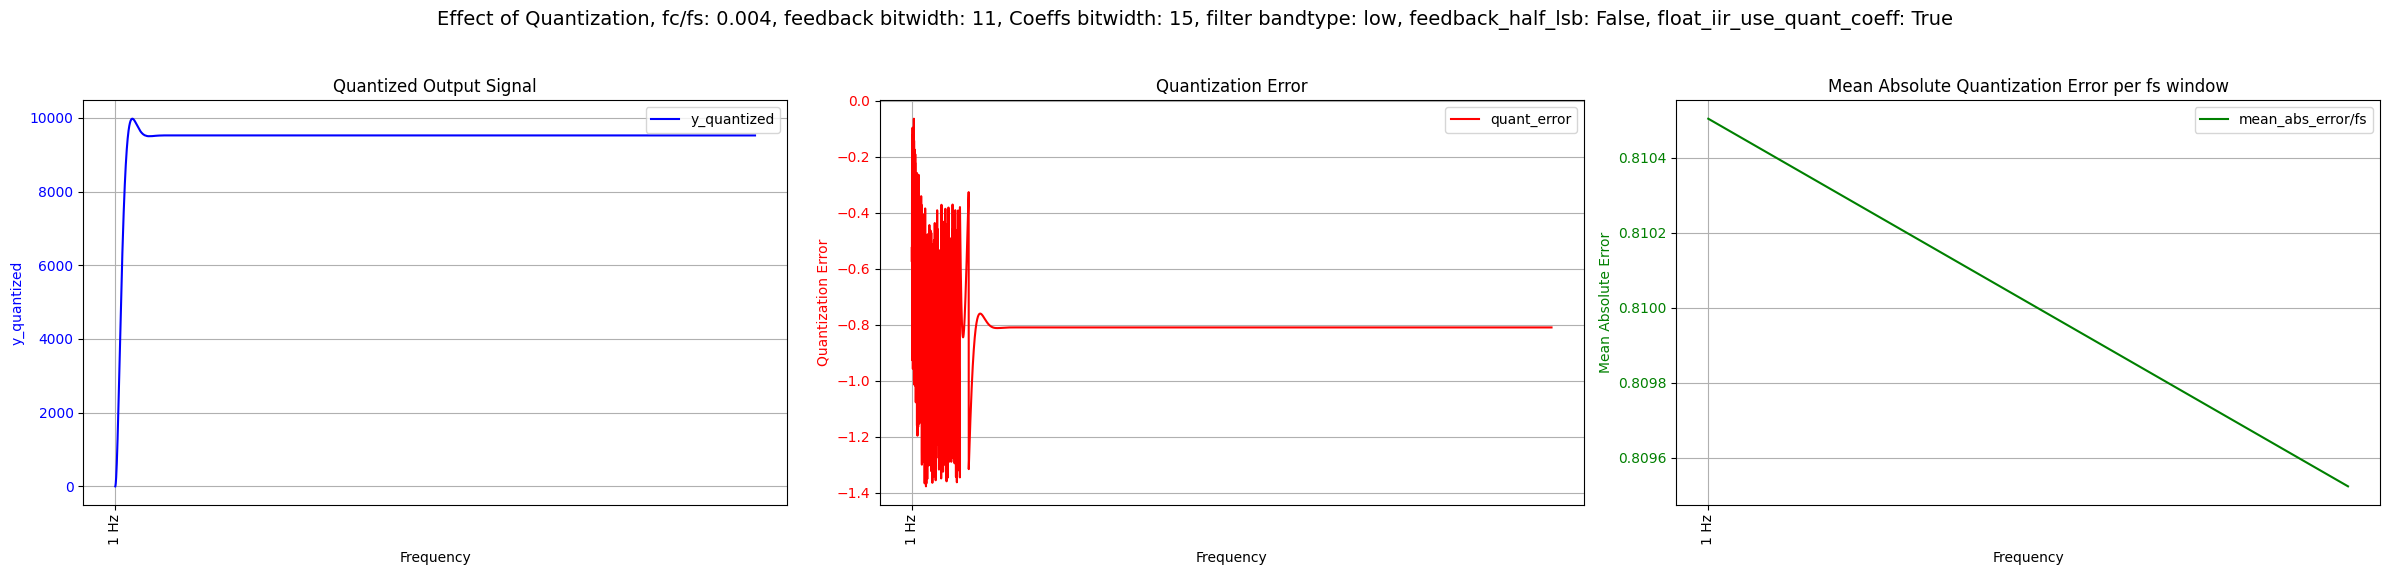

original fc_fs_ratio:  0.005
C模型加载成功!


/usr/local/lib/python3.10/dist-packages/cffi/vengine_cpy.py:191: UserWarning: reimporting '_cffi__xadf2c5f3xa514687e' might overwrite older definitions
  warnings.warn("reimporting %r might overwrite older definitions"


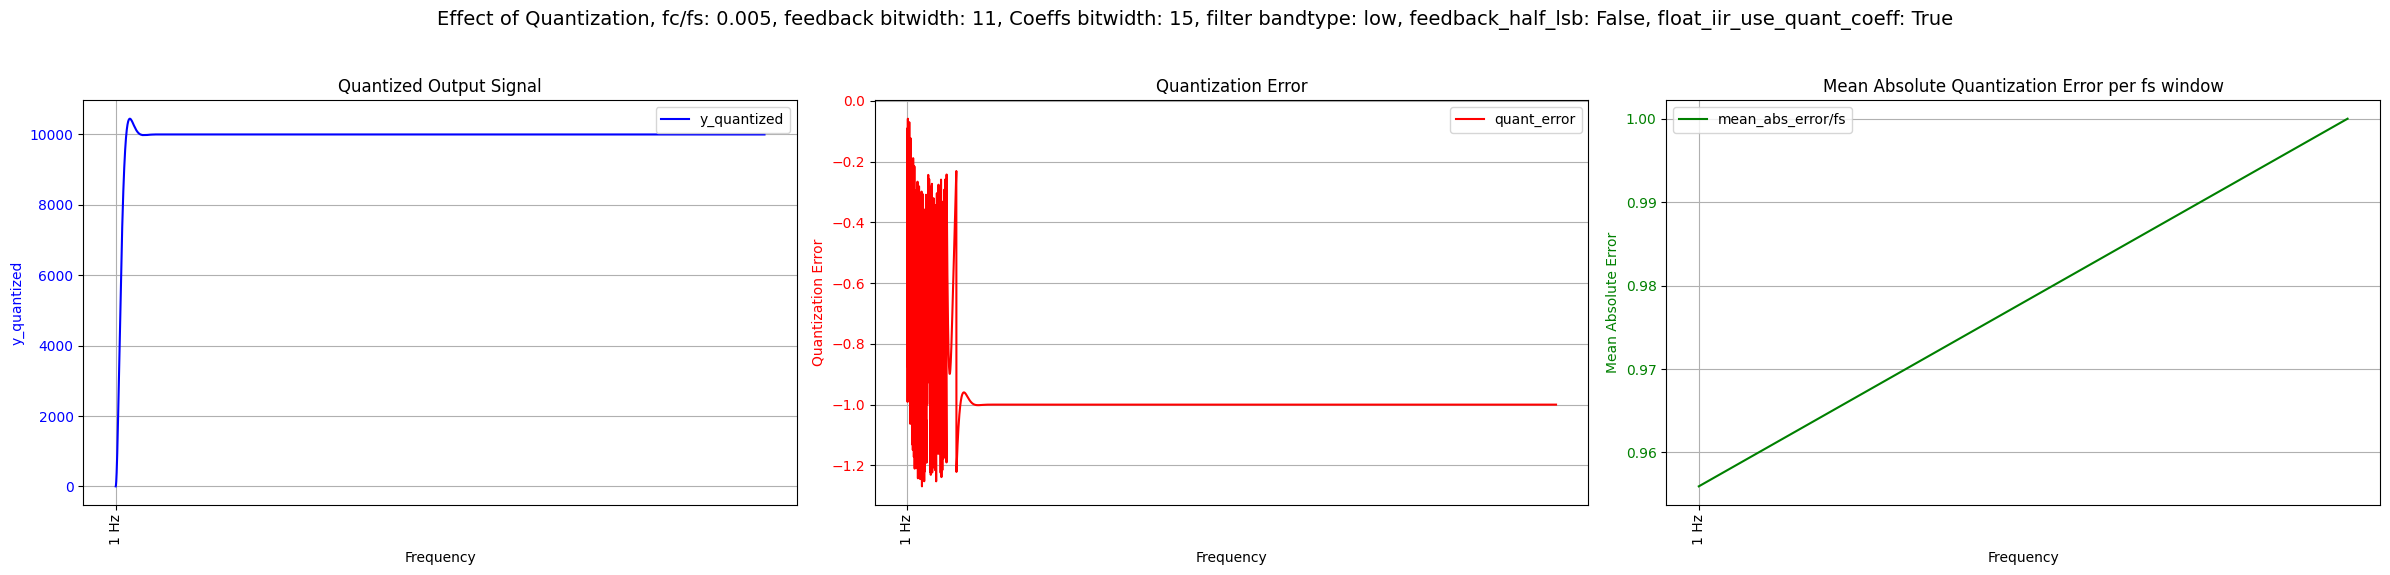

original fc_fs_ratio:  0.006
C模型加载成功!


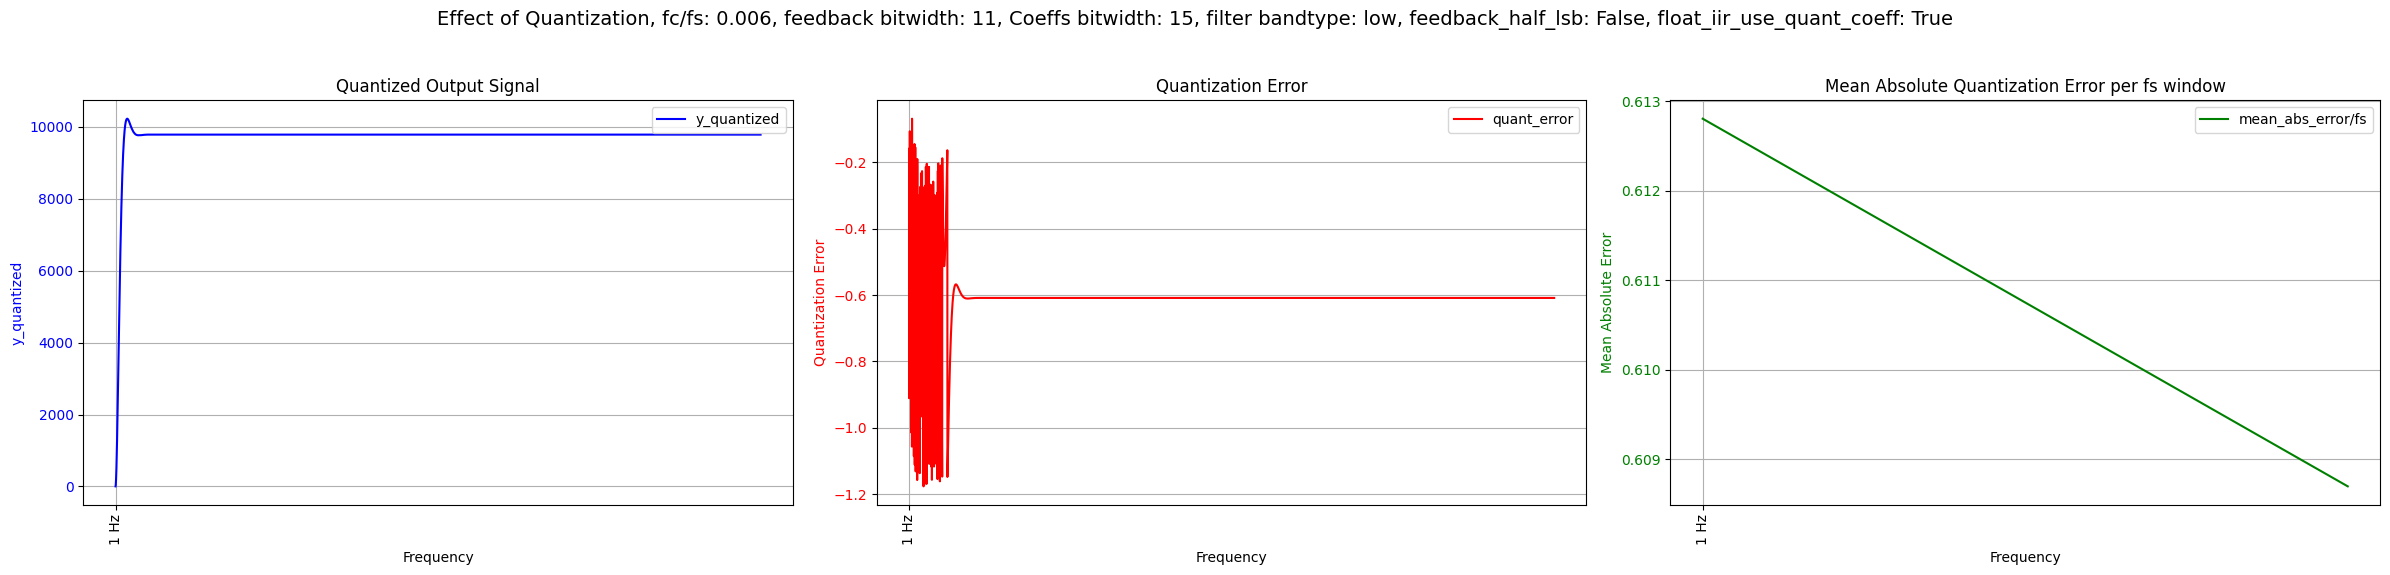

original fc_fs_ratio:  0.007
C模型加载成功!


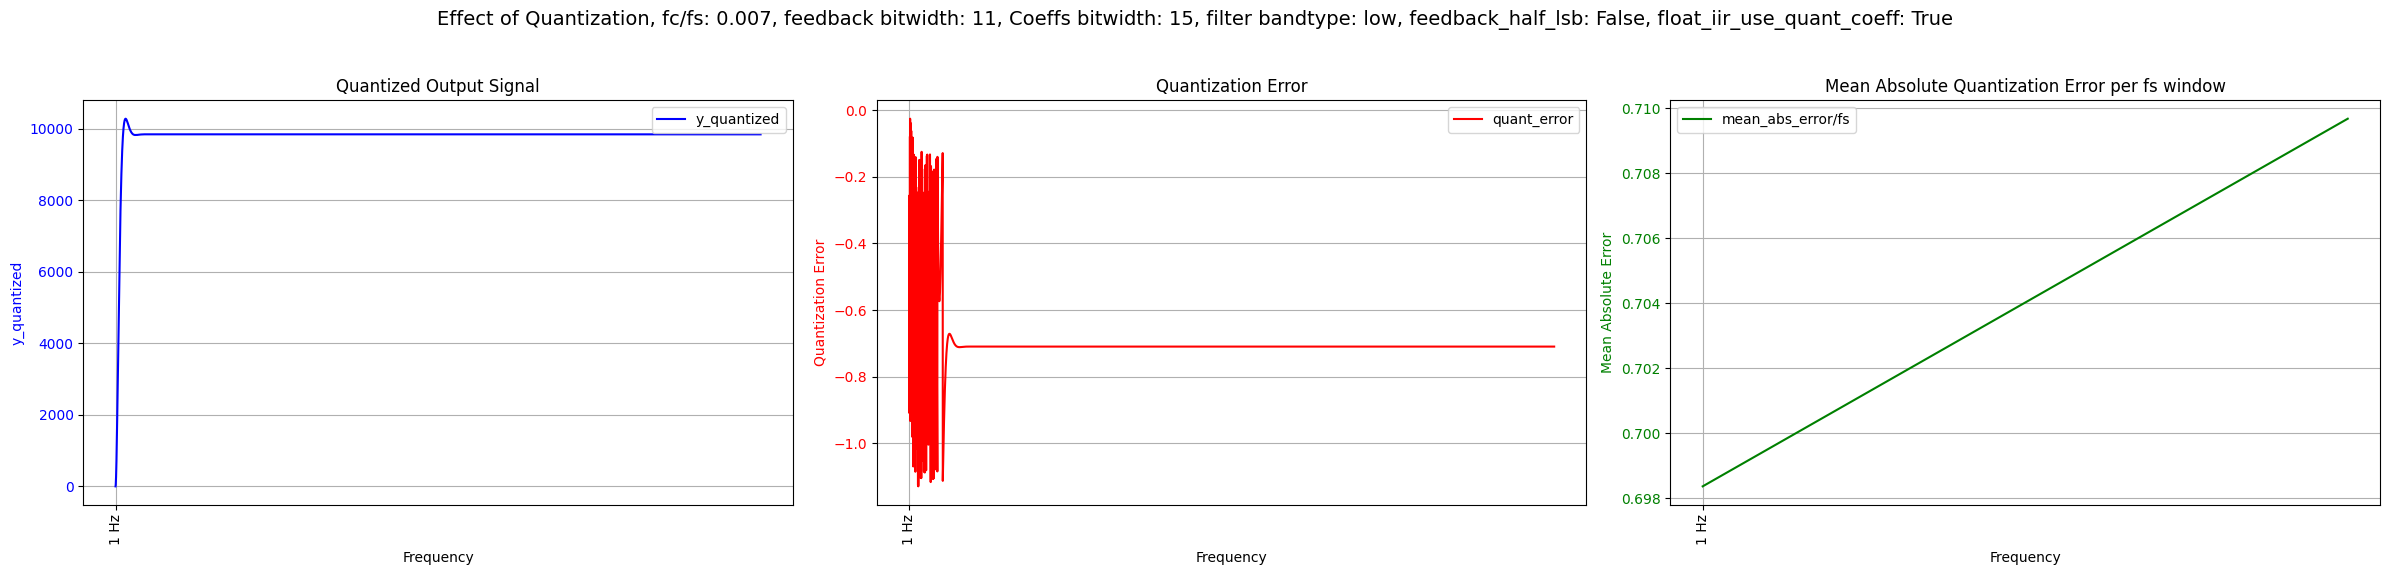

original fc_fs_ratio:  0.008
C模型加载成功!


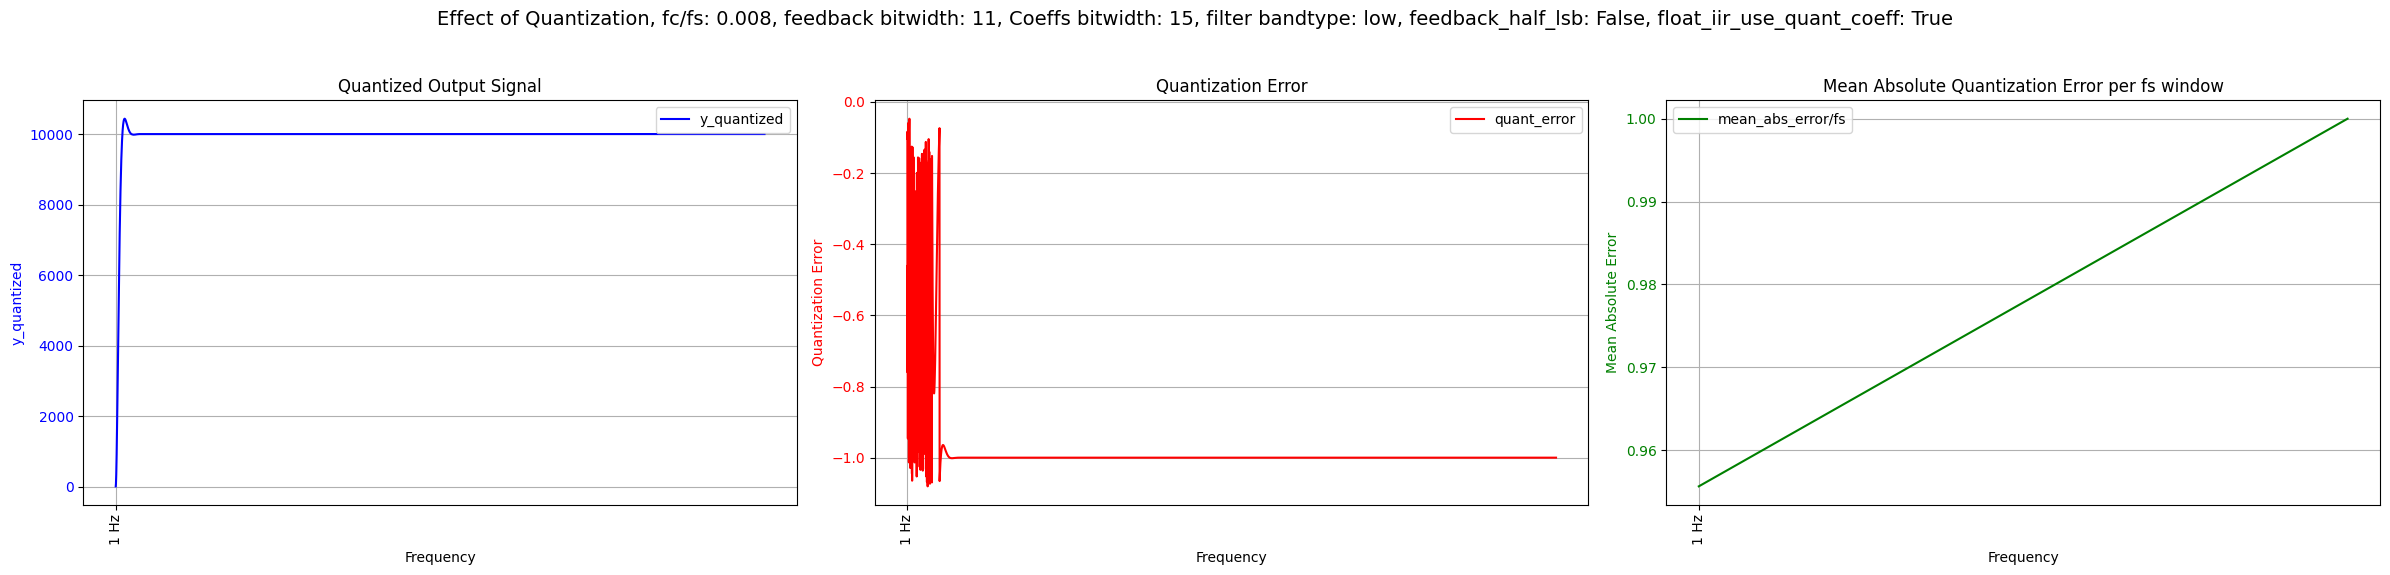

original fc_fs_ratio:  0.009
C模型加载成功!


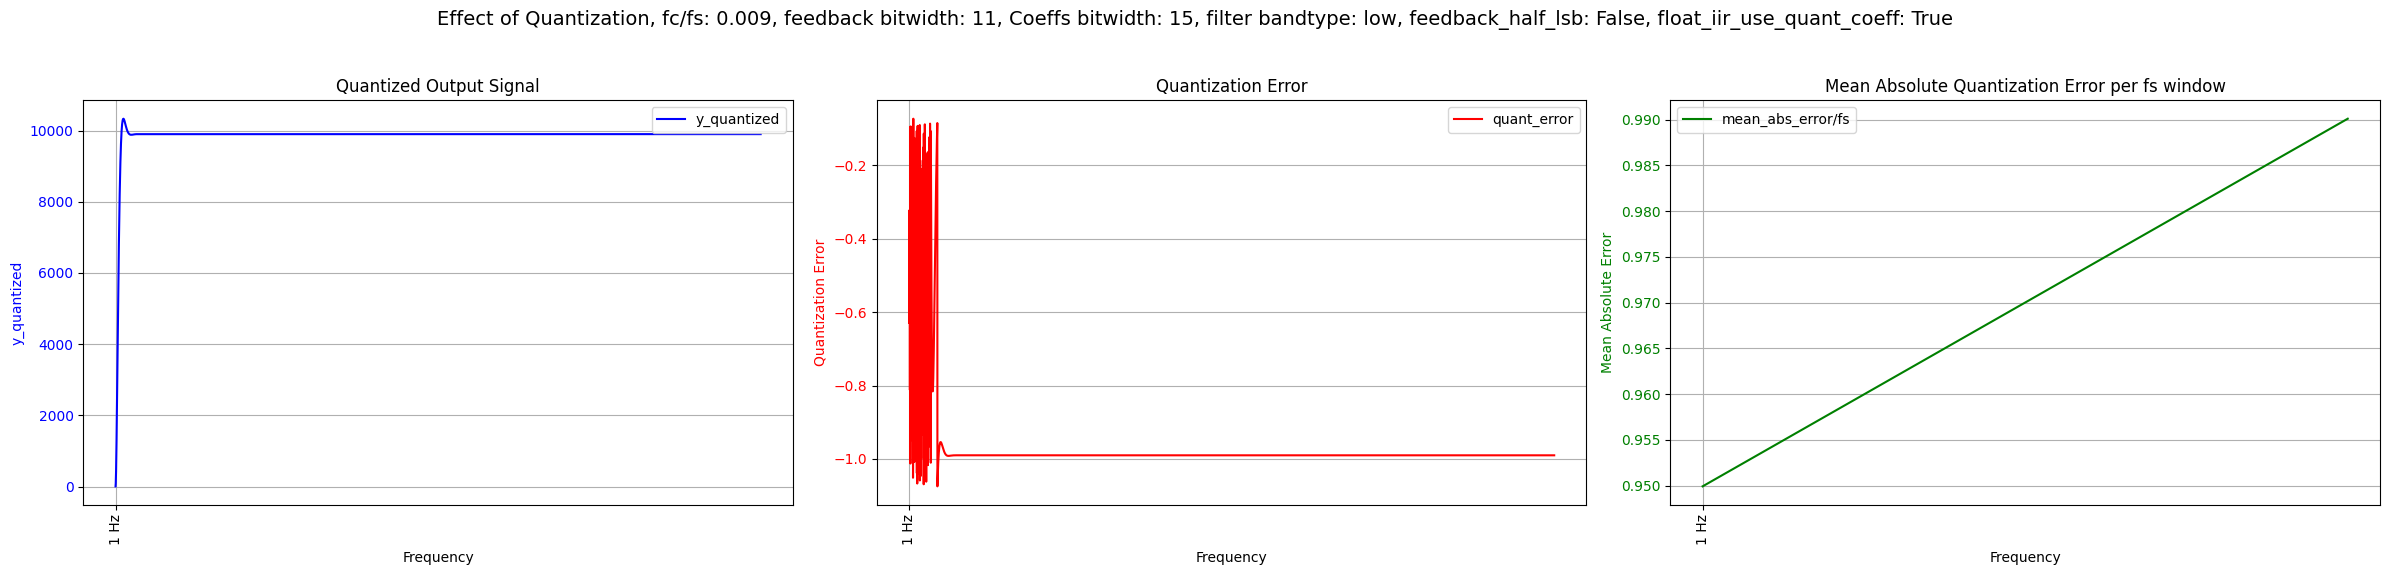

original fc_fs_ratio:  0.01
C模型加载成功!


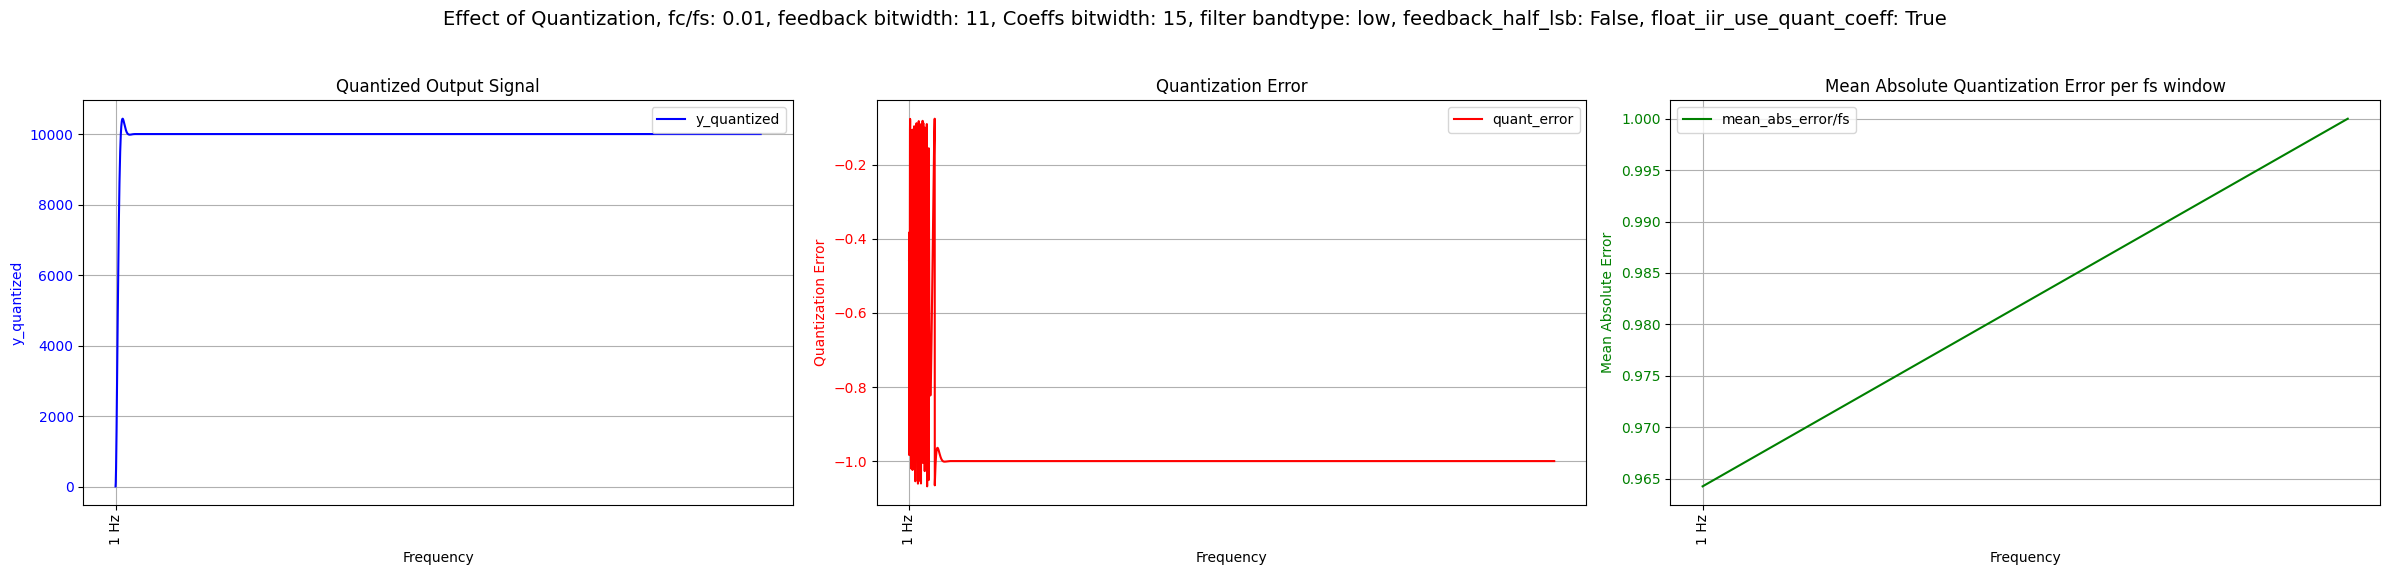

original fc_fs_ratio:  0.02
C模型加载成功!


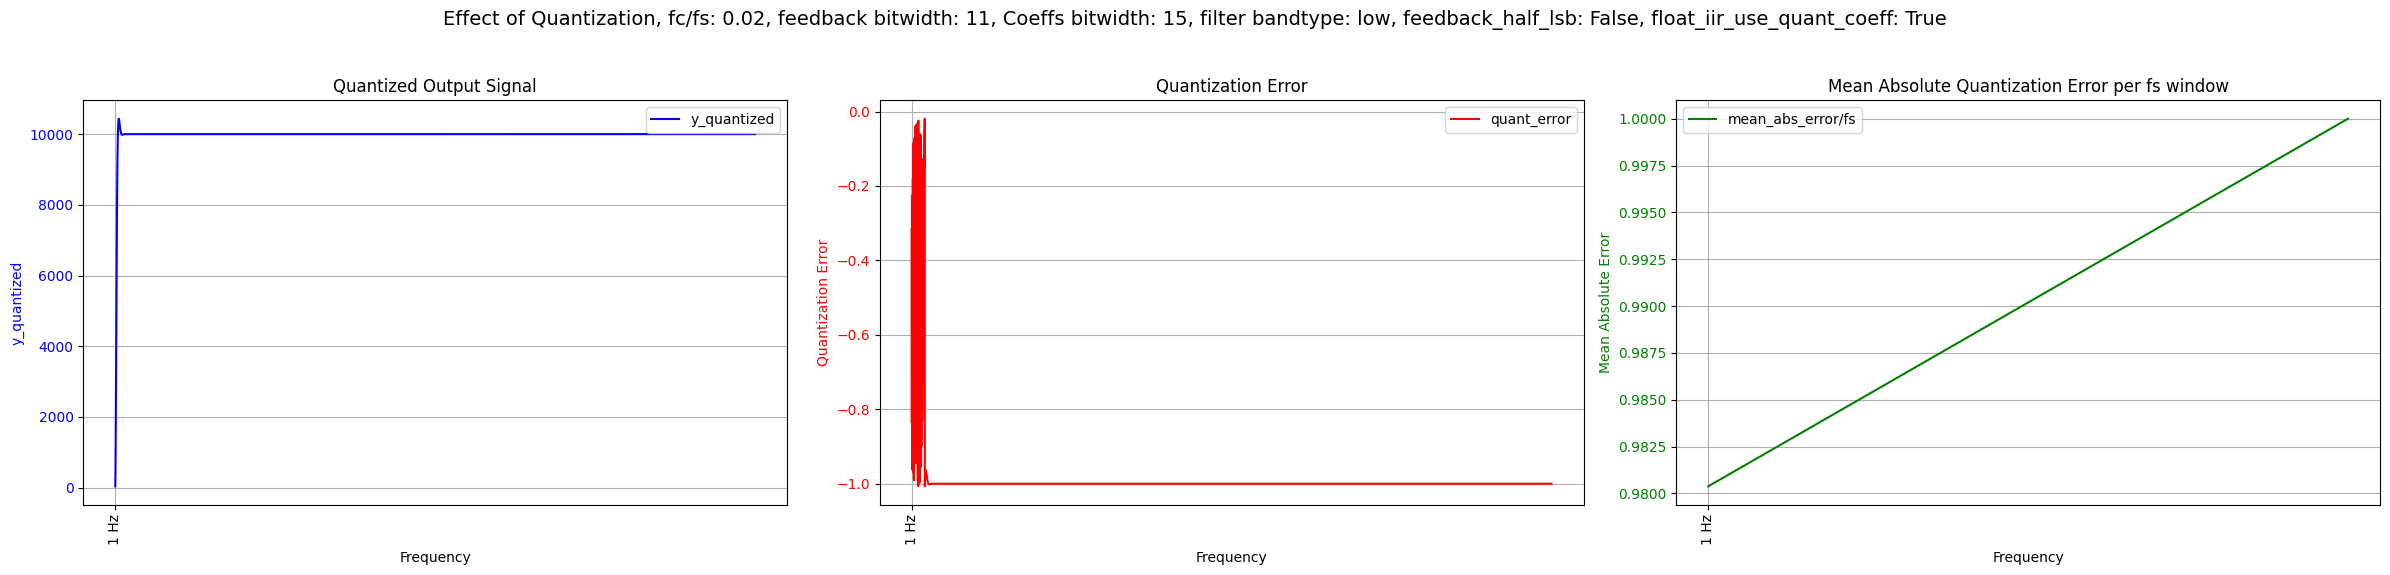

original fc_fs_ratio:  0.03
C模型加载成功!


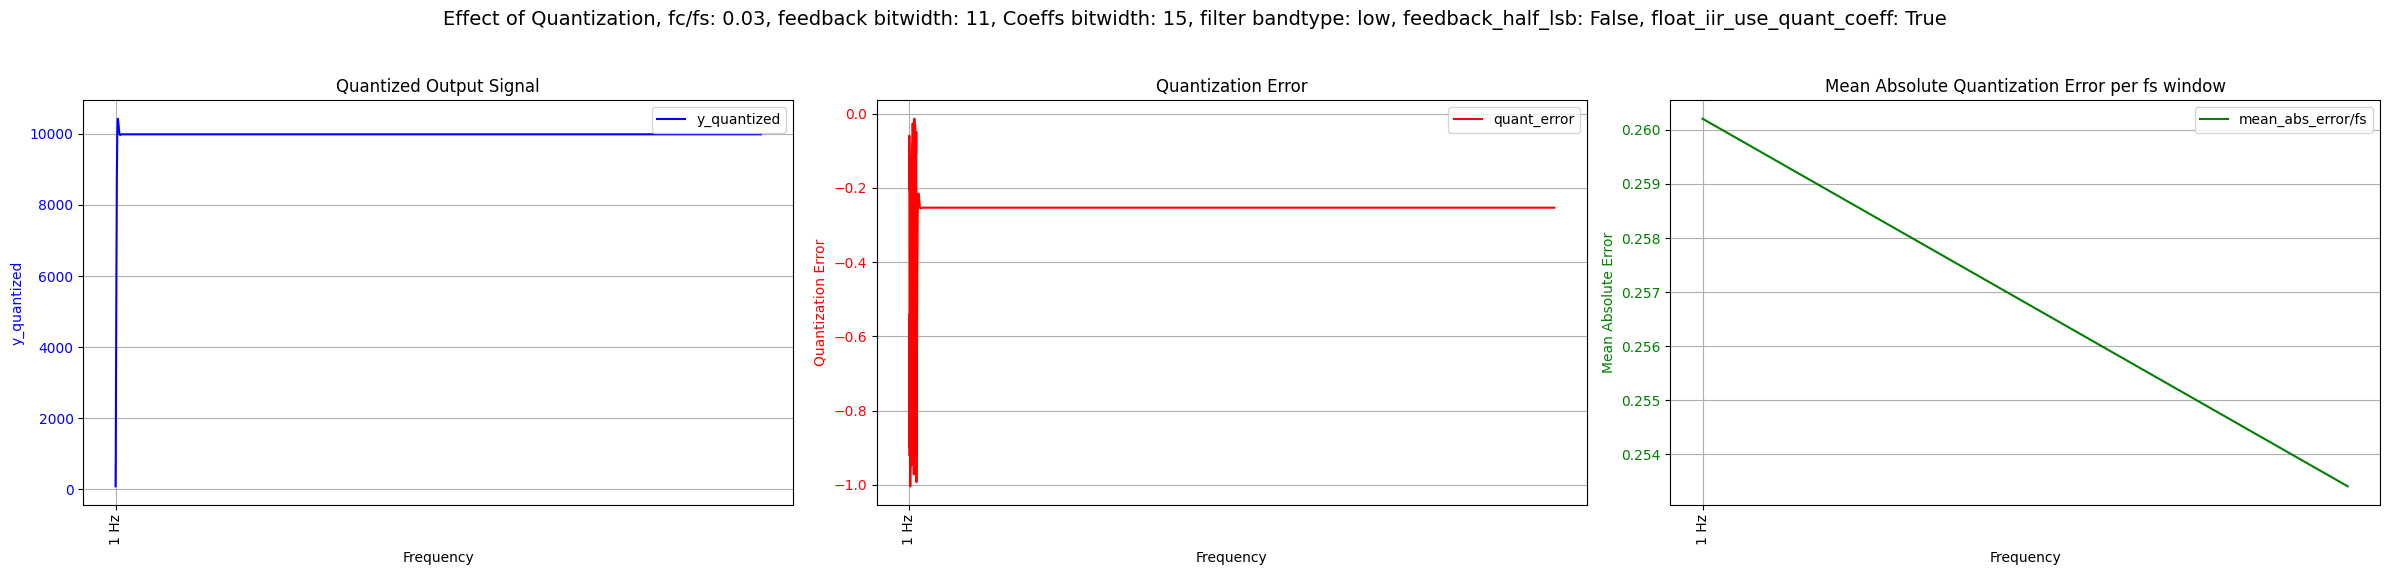

original fc_fs_ratio:  0.04
C模型加载成功!


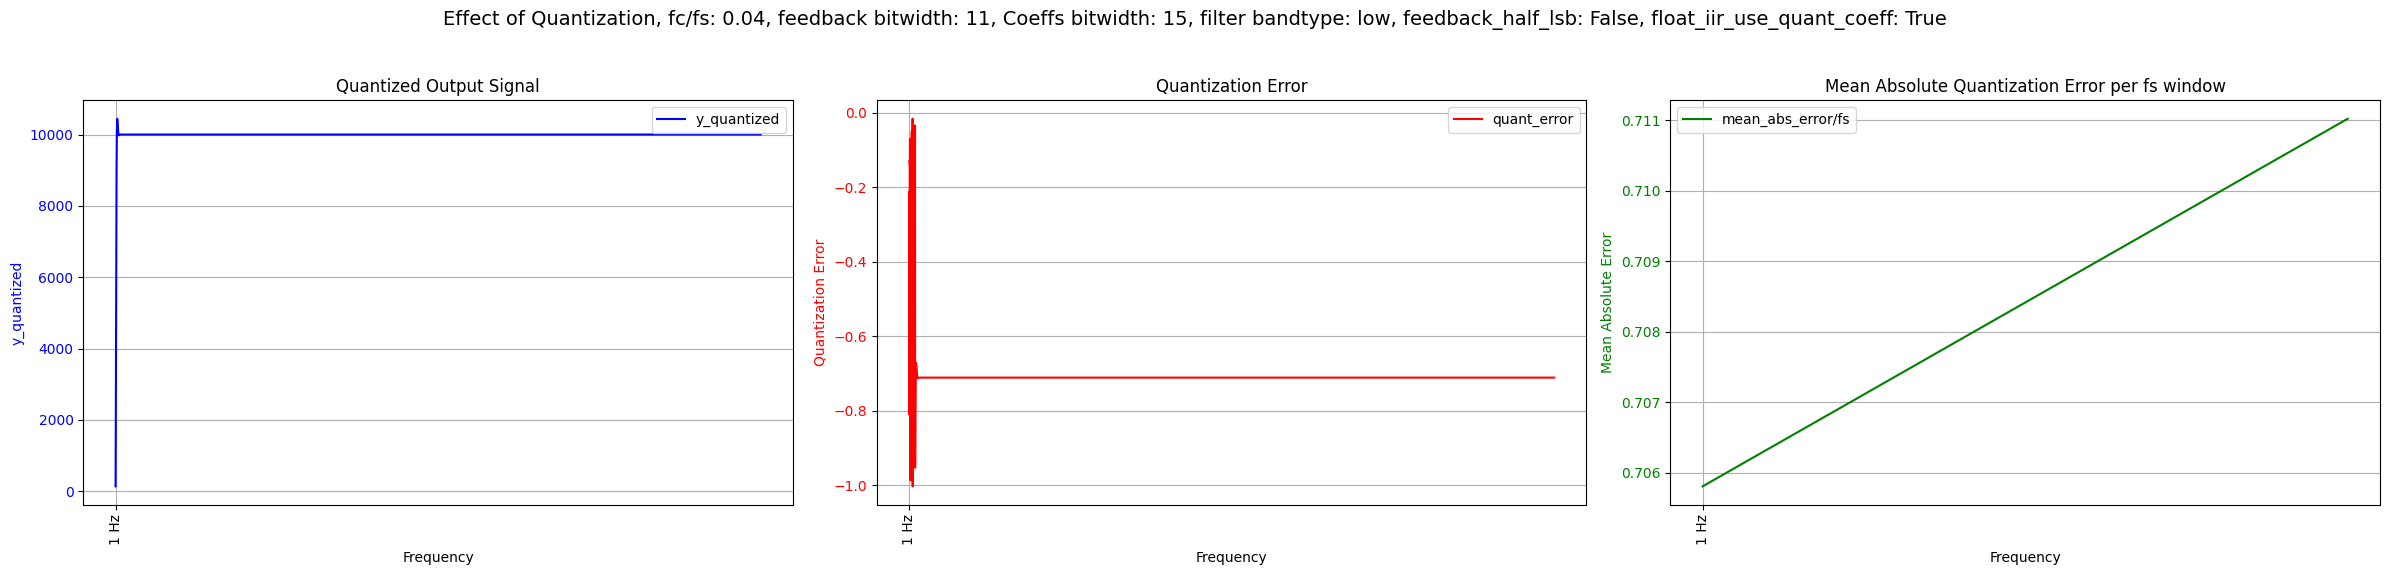

original fc_fs_ratio:  0.05
C模型加载成功!


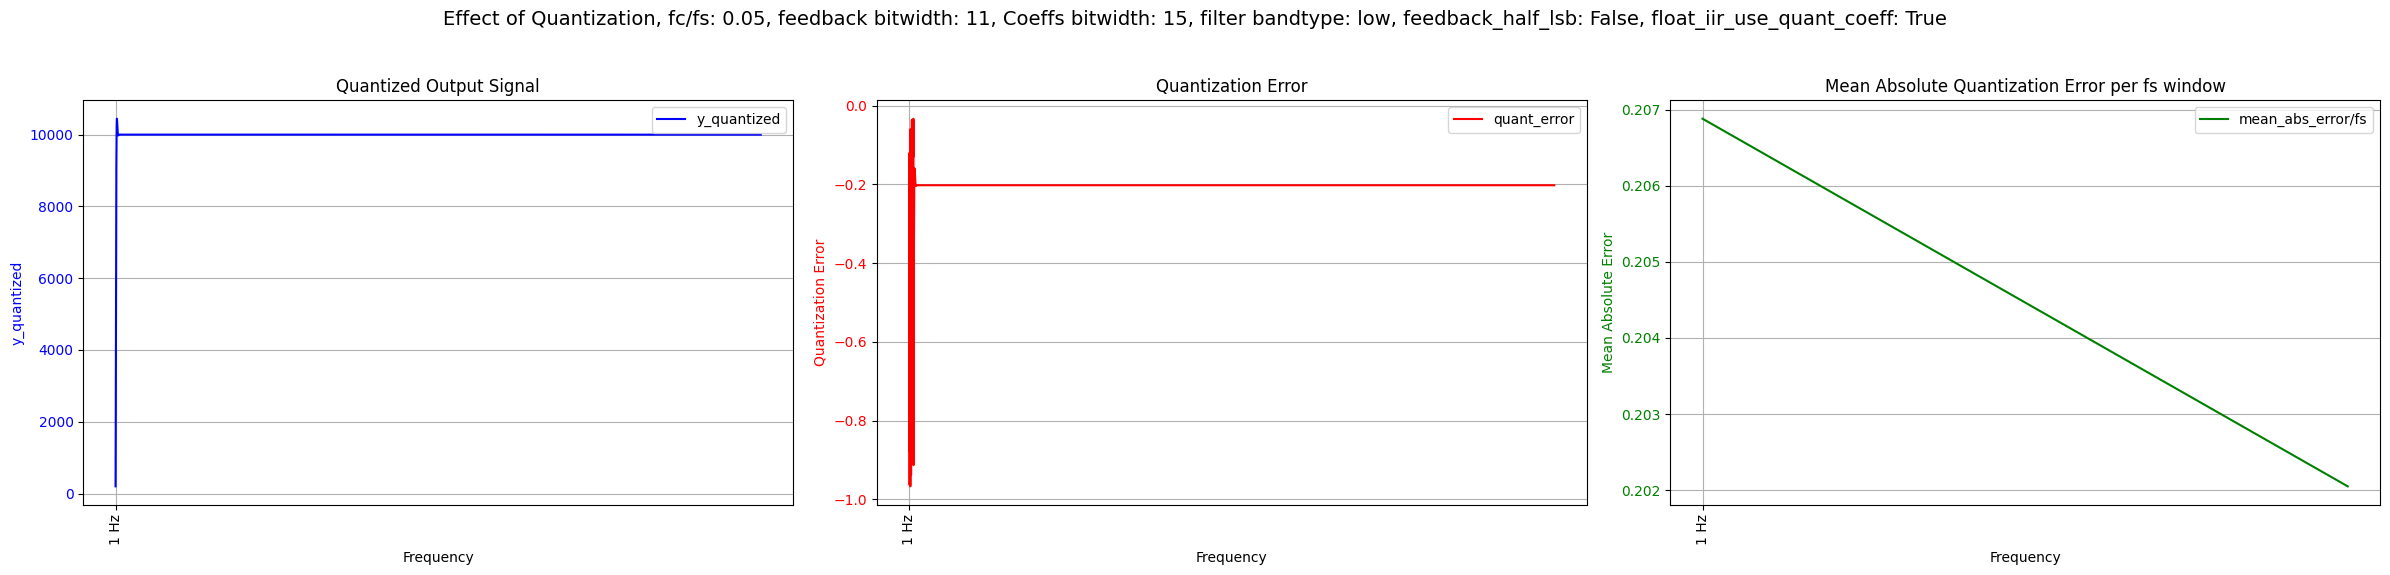

original fc_fs_ratio:  0.06
C模型加载成功!


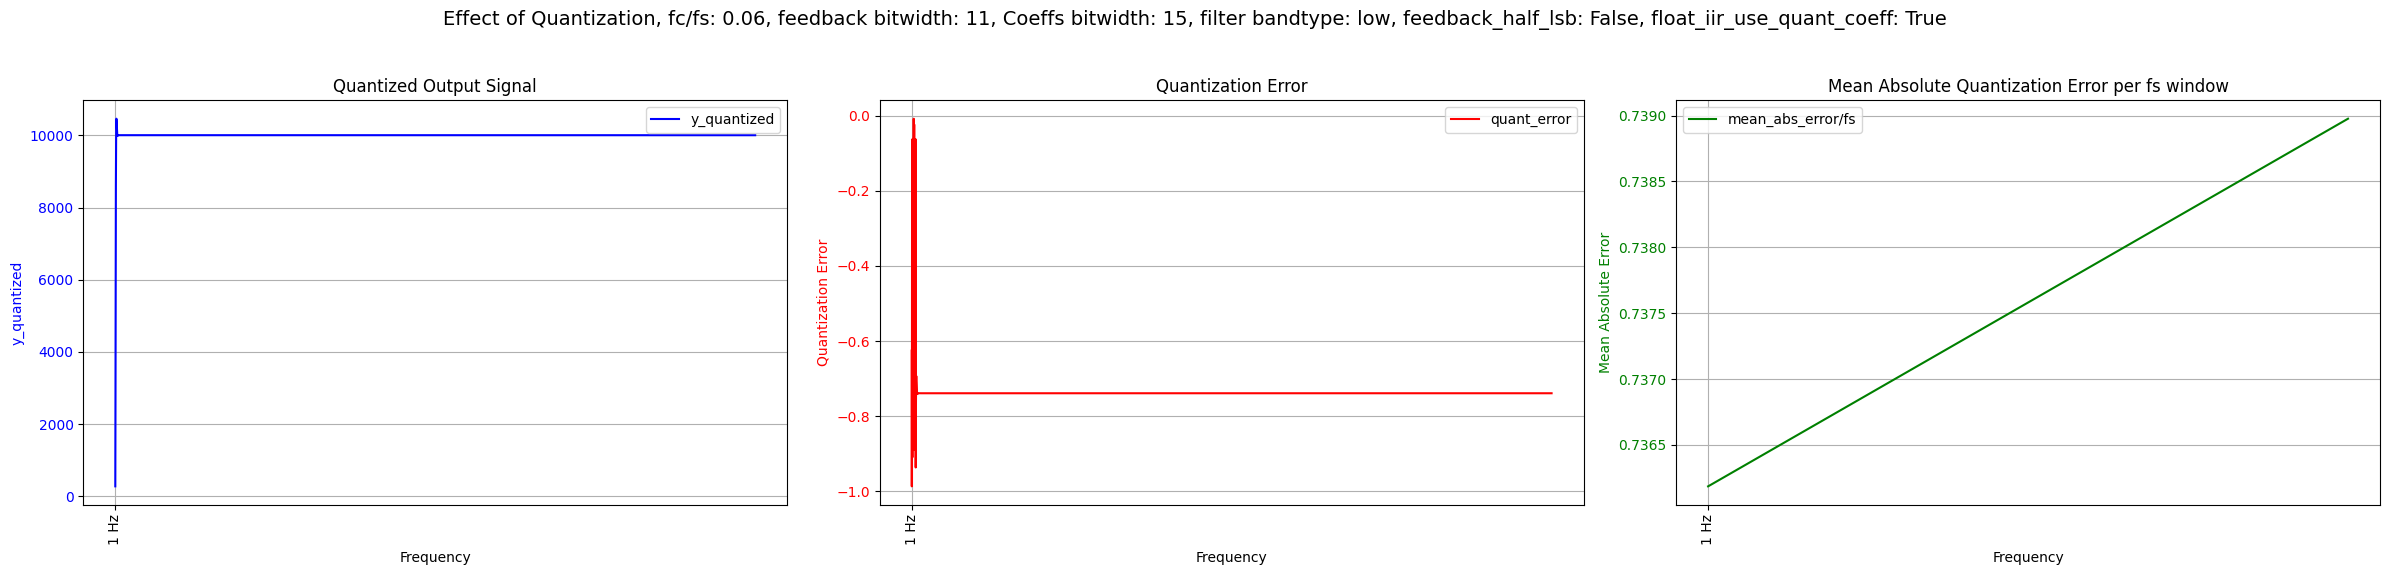

original fc_fs_ratio:  0.07
C模型加载成功!


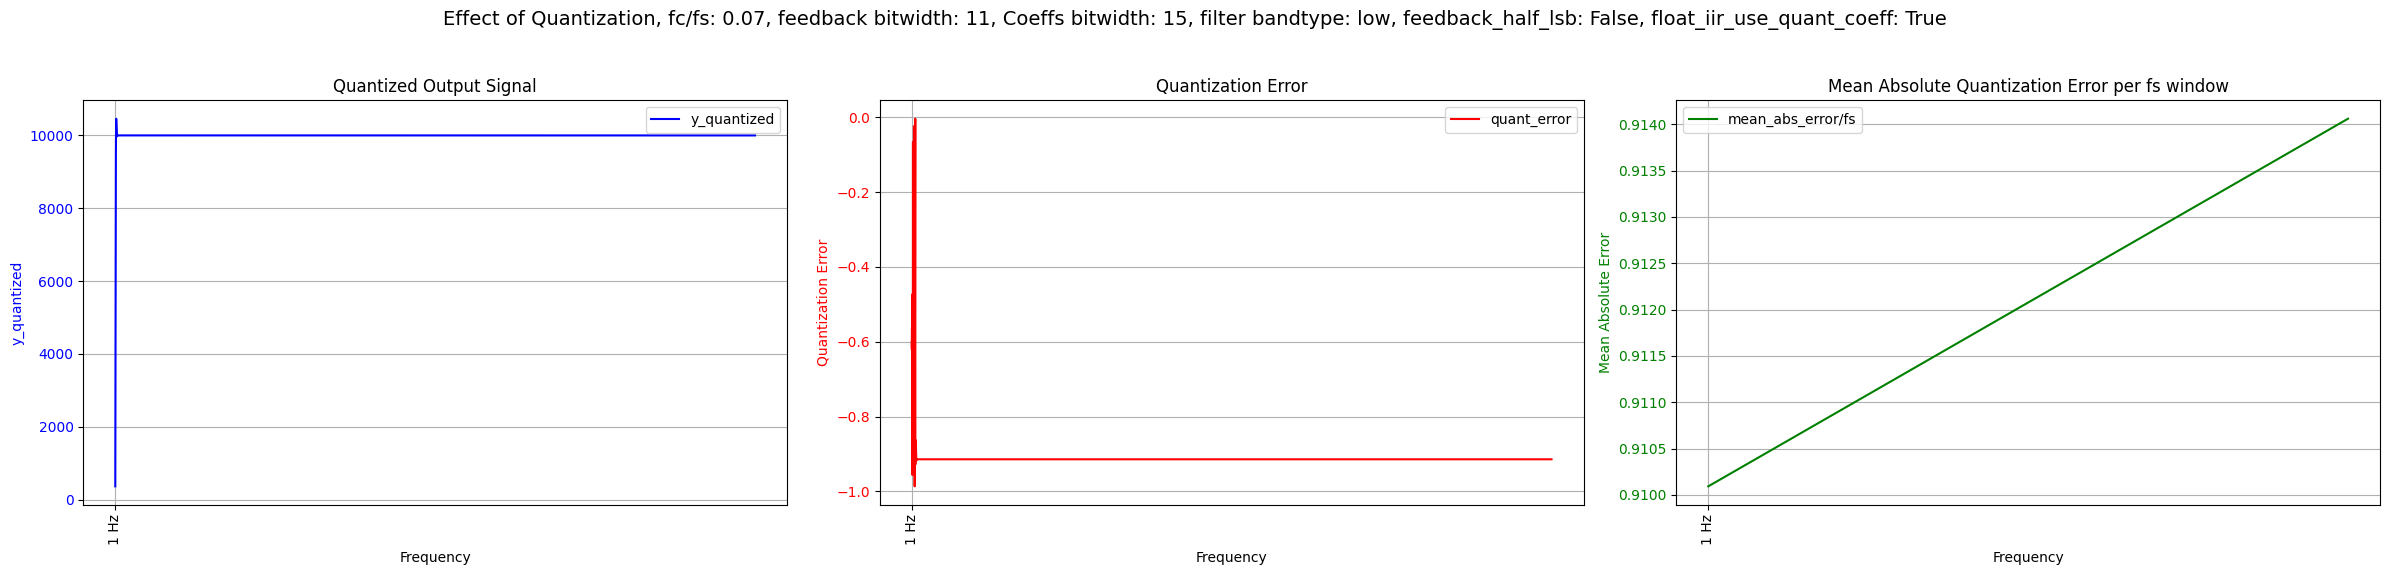

original fc_fs_ratio:  0.08
C模型加载成功!


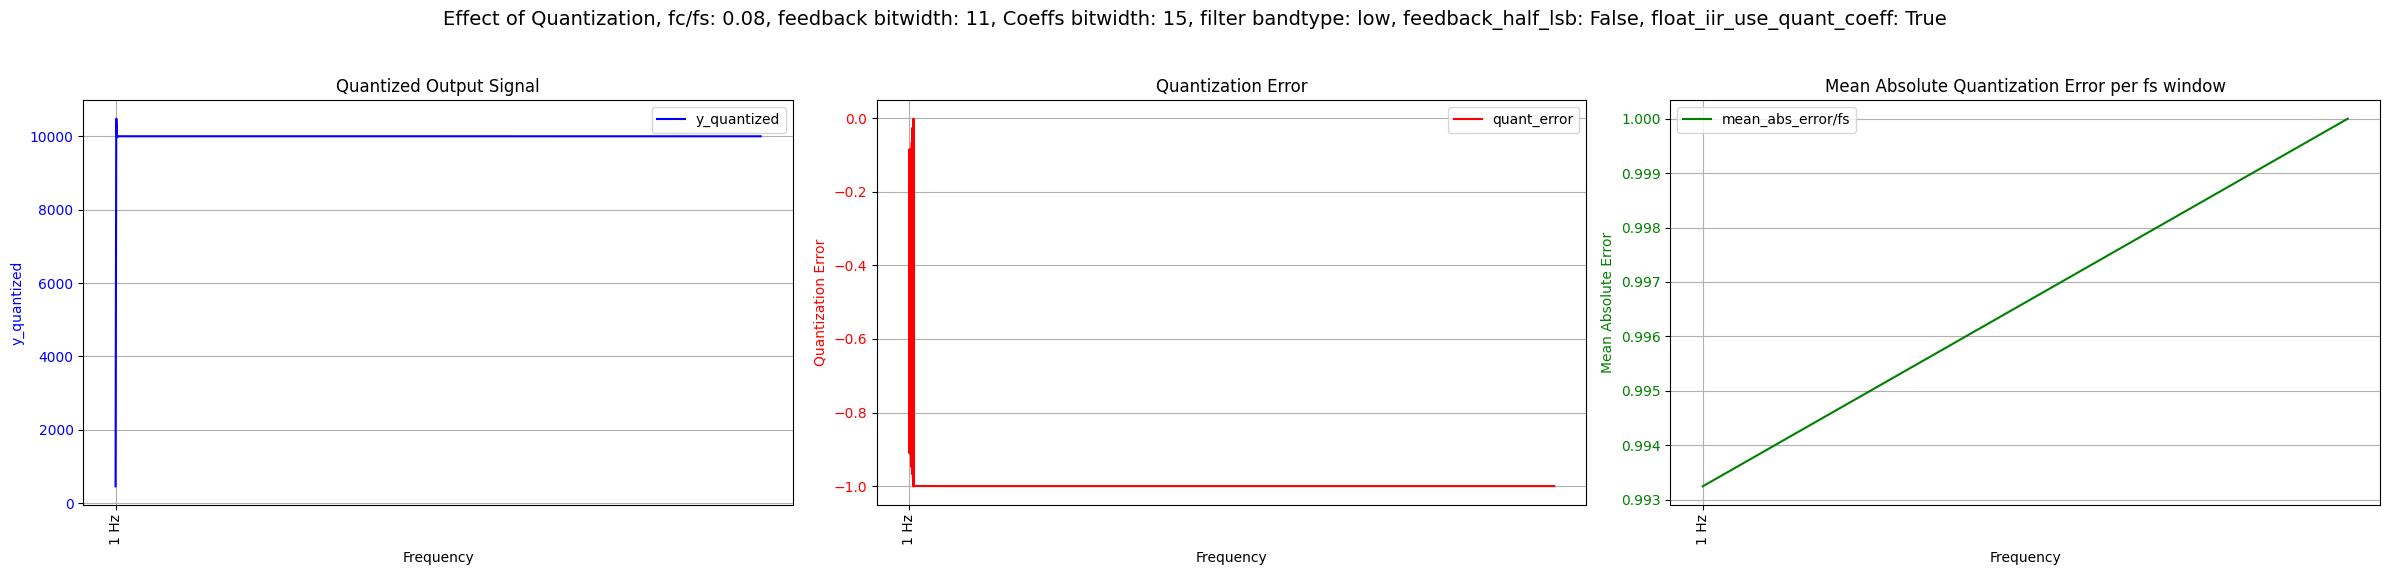

original fc_fs_ratio:  0.09
C模型加载成功!


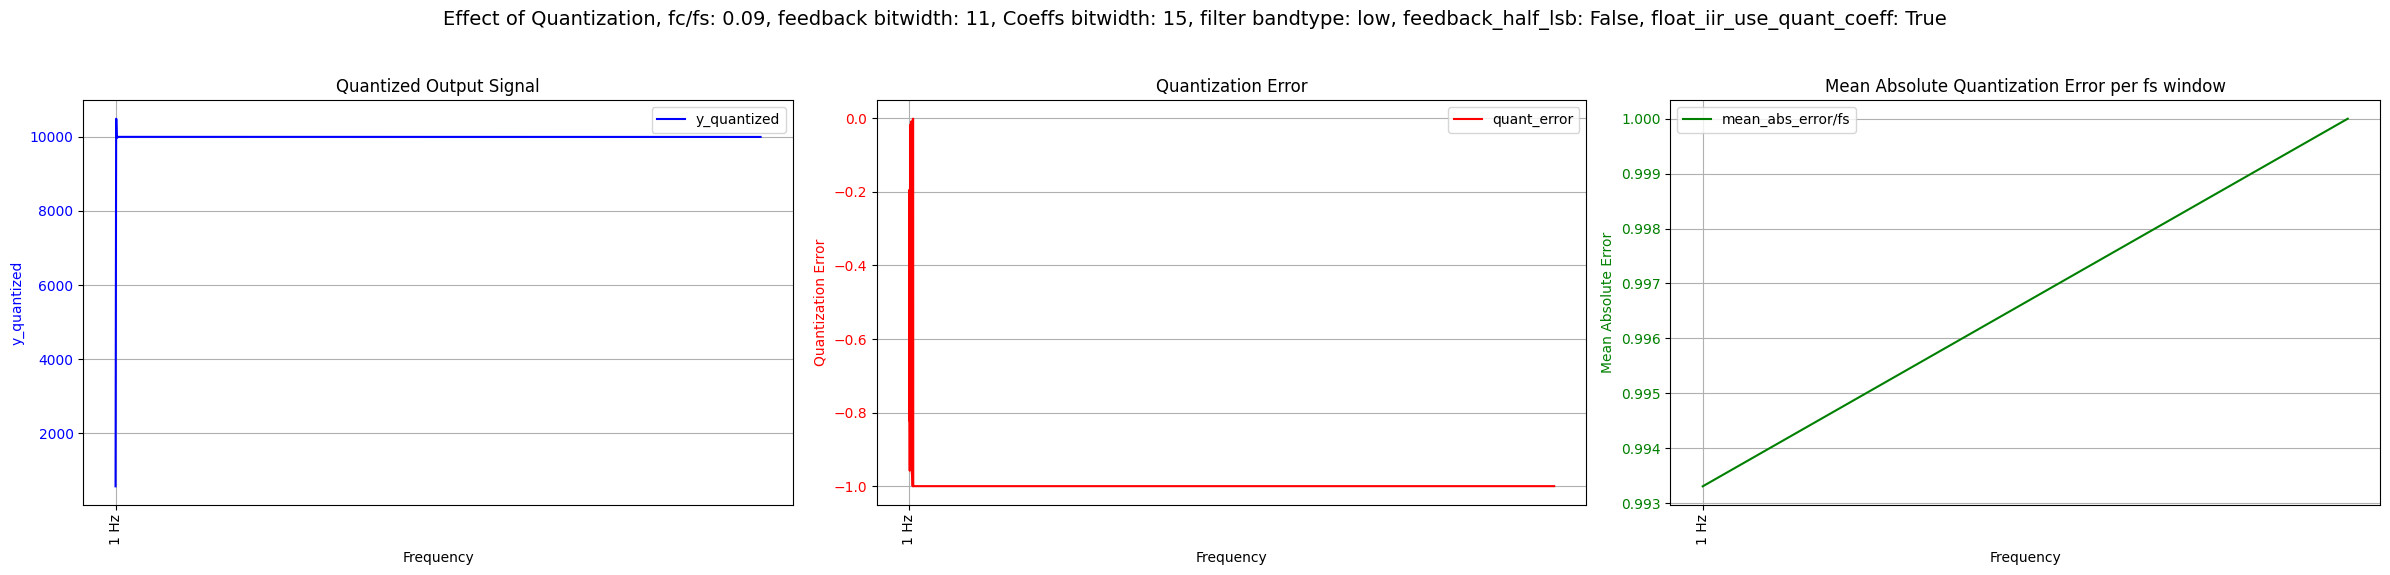

original fc_fs_ratio:  0.1
C模型加载成功!


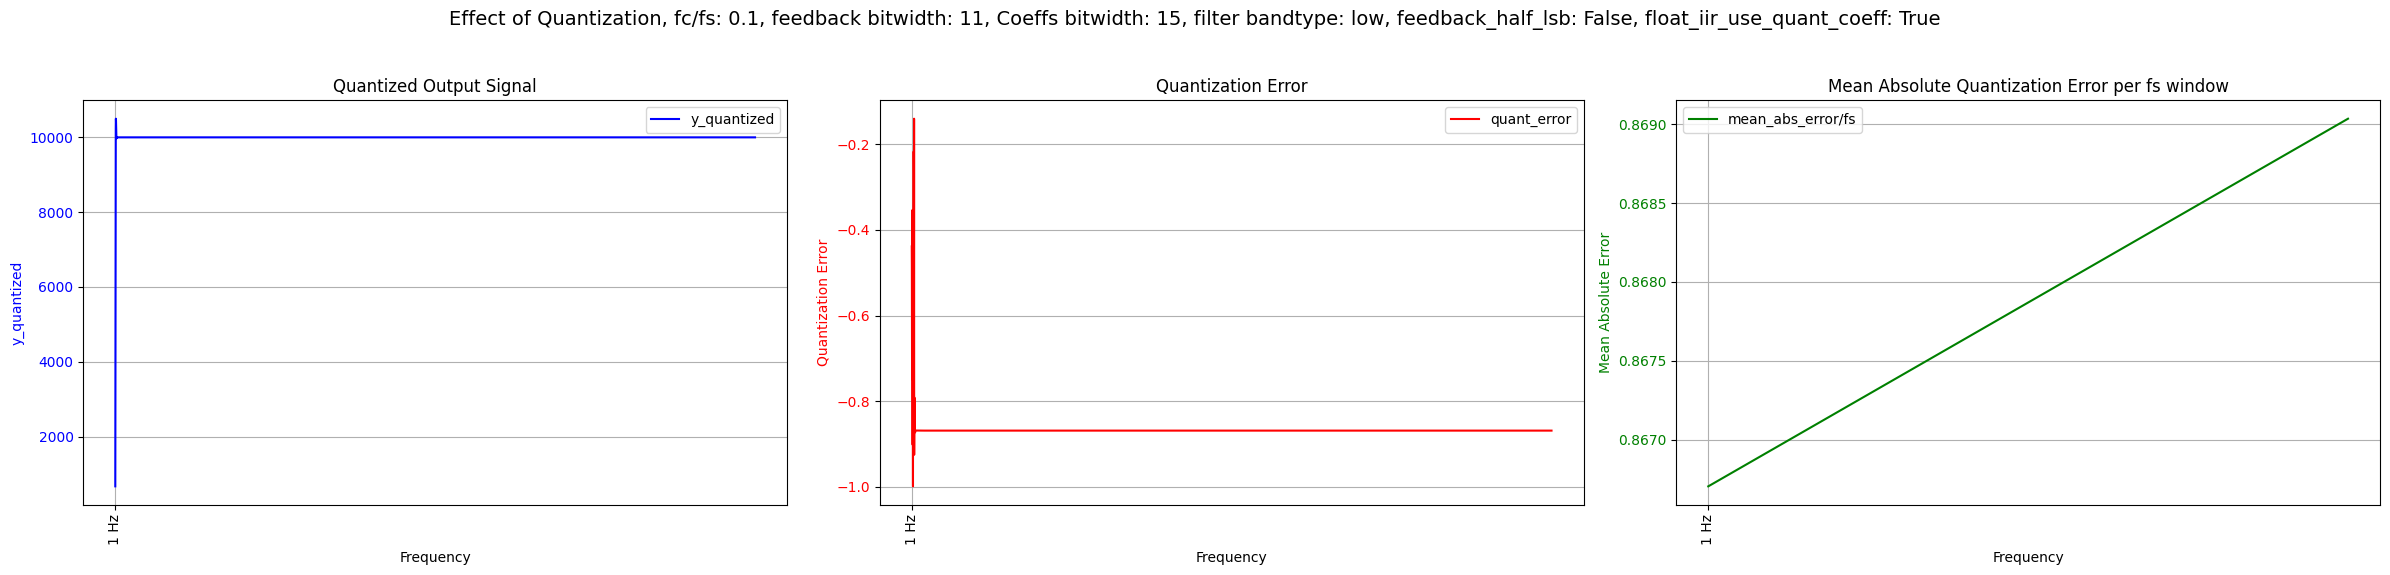

original fc_fs_ratio:  0.12
C模型加载成功!


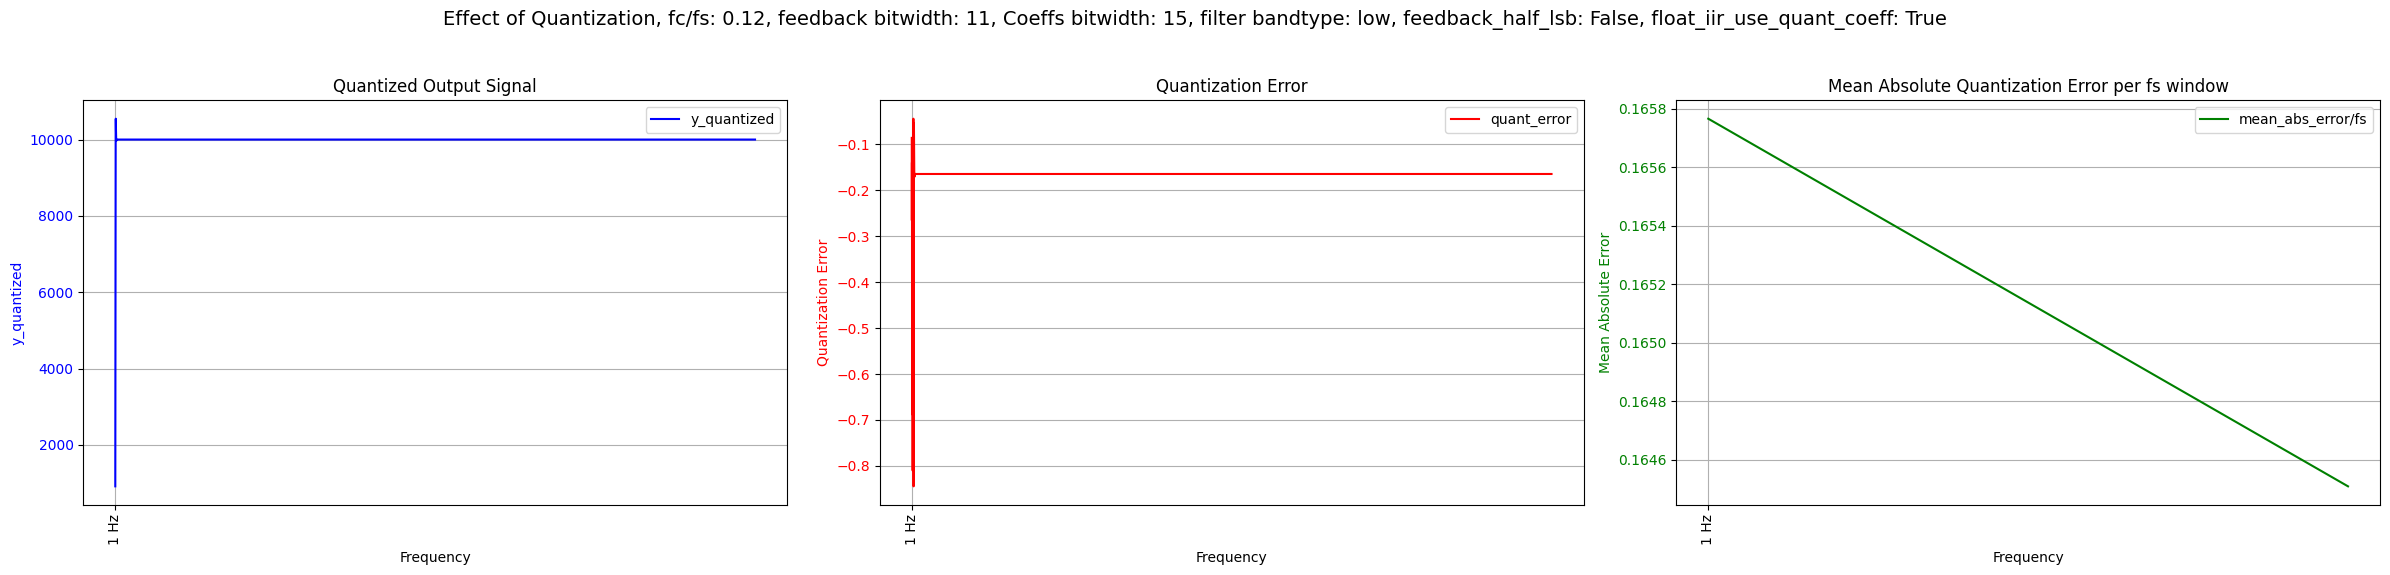

original fc_fs_ratio:  0.14
C模型加载成功!


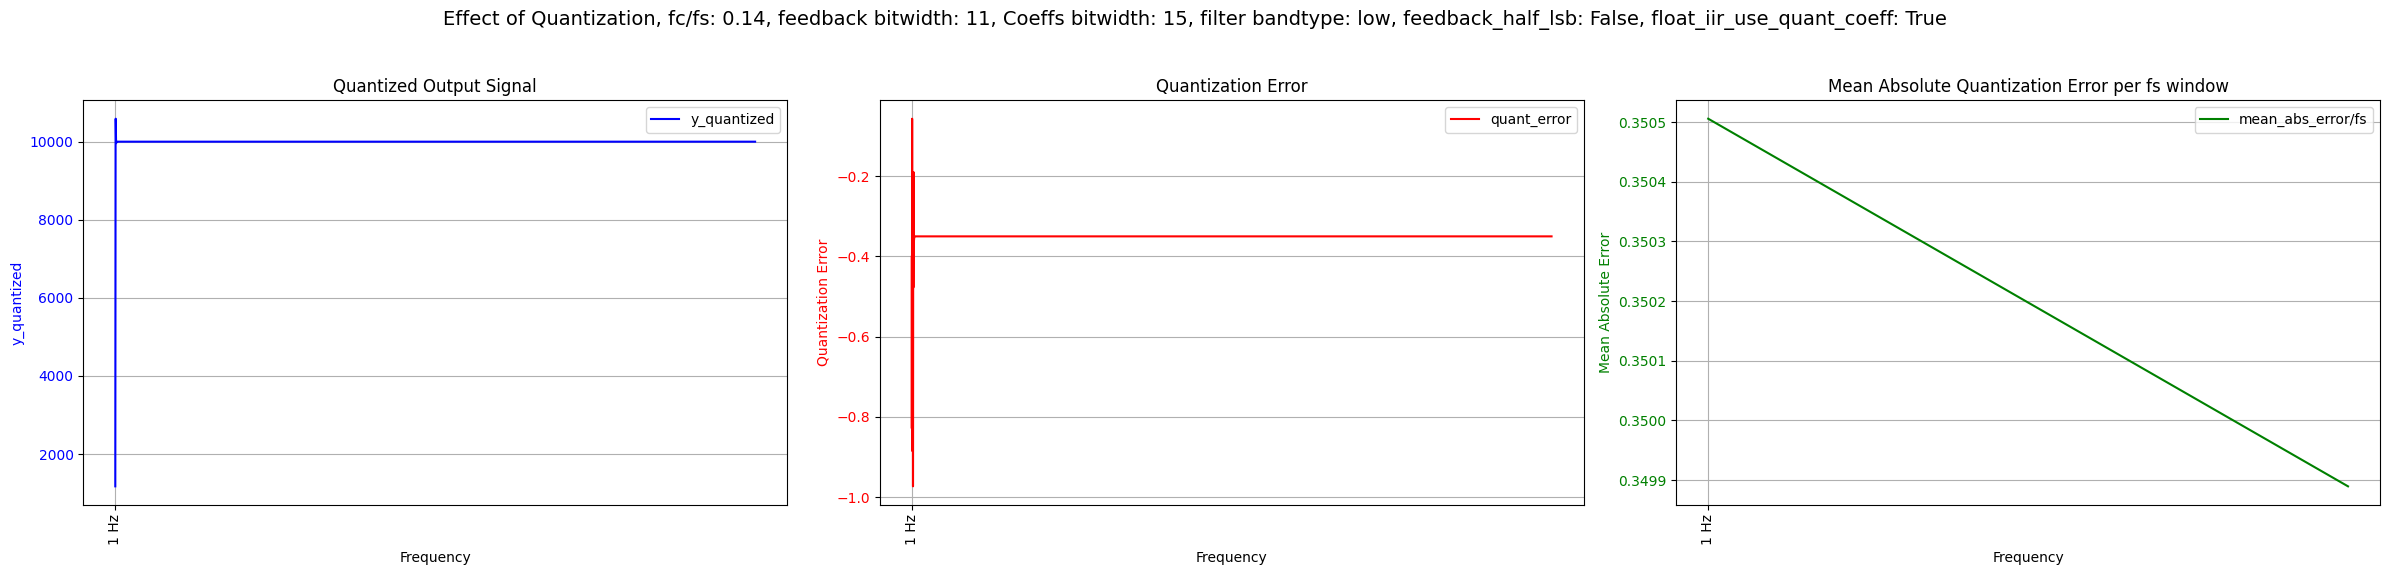

original fc_fs_ratio:  0.16
C模型加载成功!


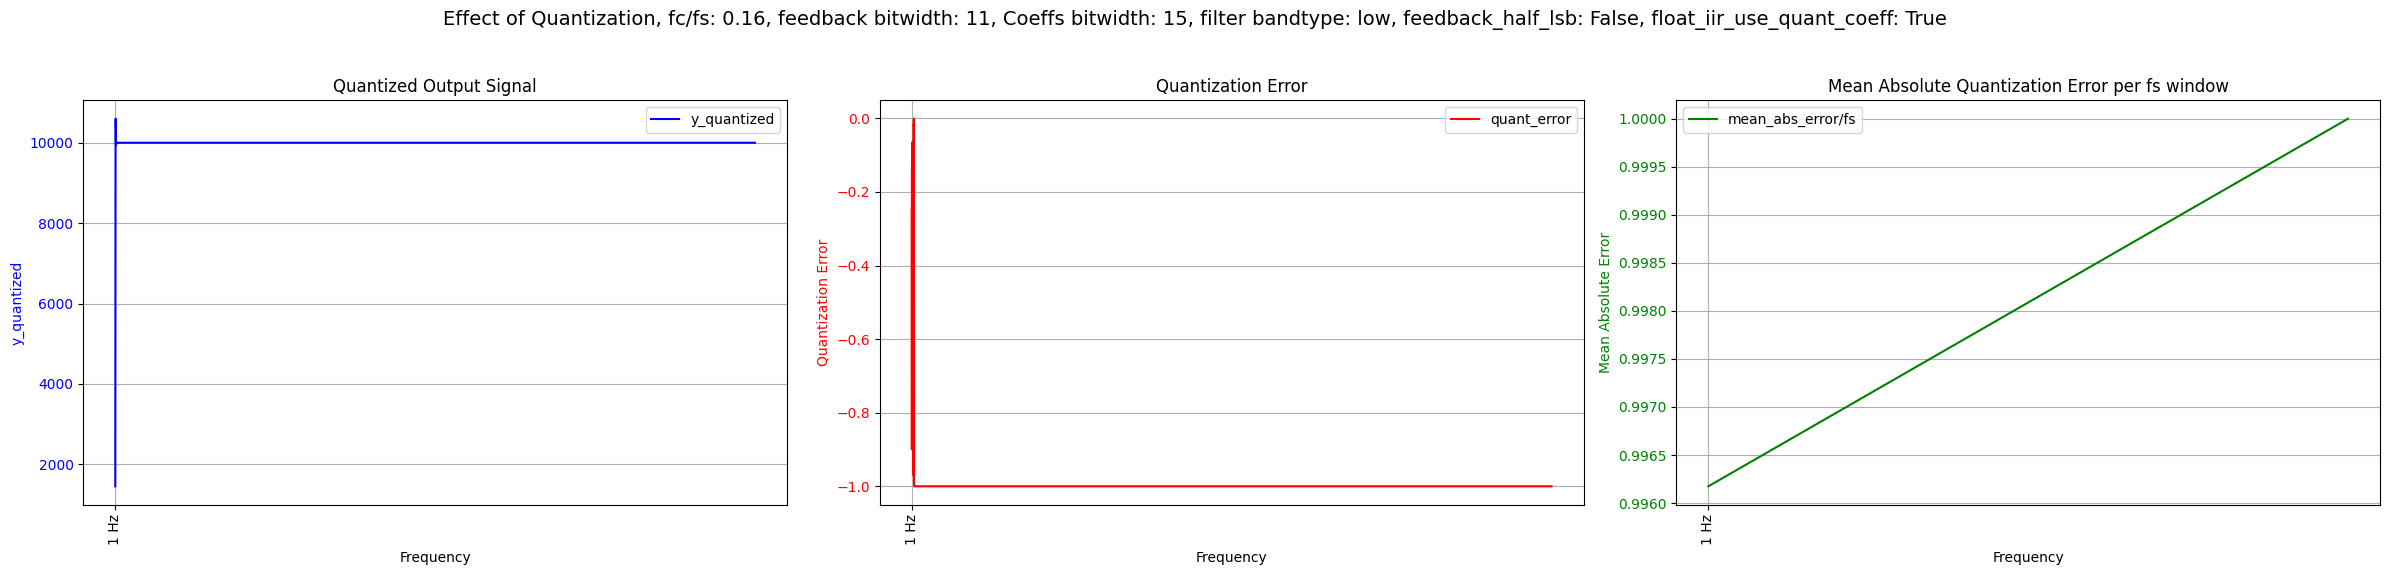

original fc_fs_ratio:  0.18
C模型加载成功!


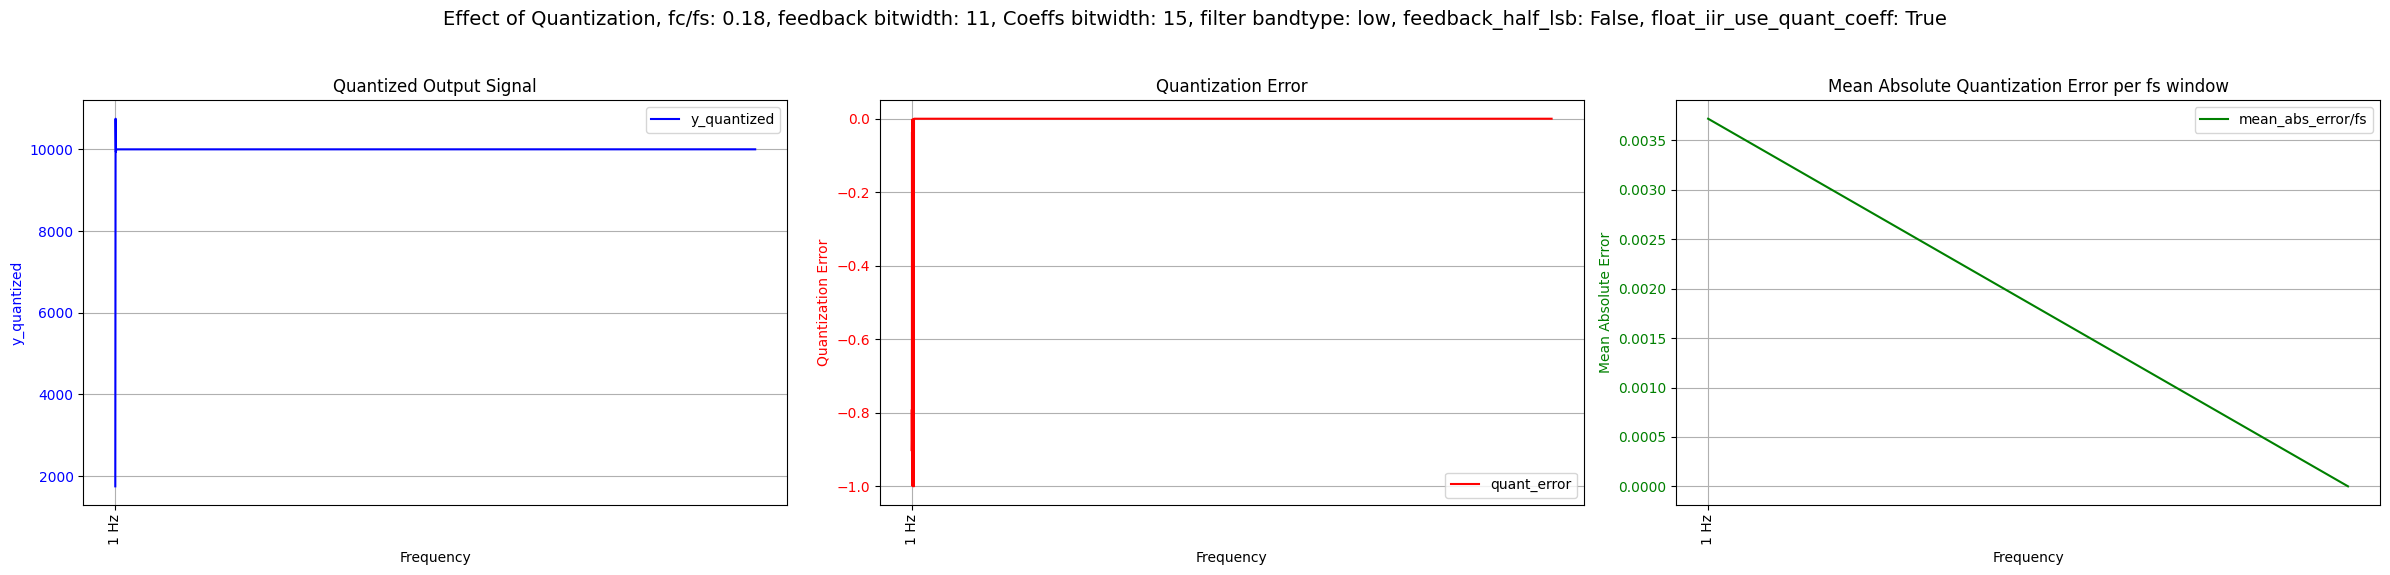

original fc_fs_ratio:  0.2
C模型加载成功!


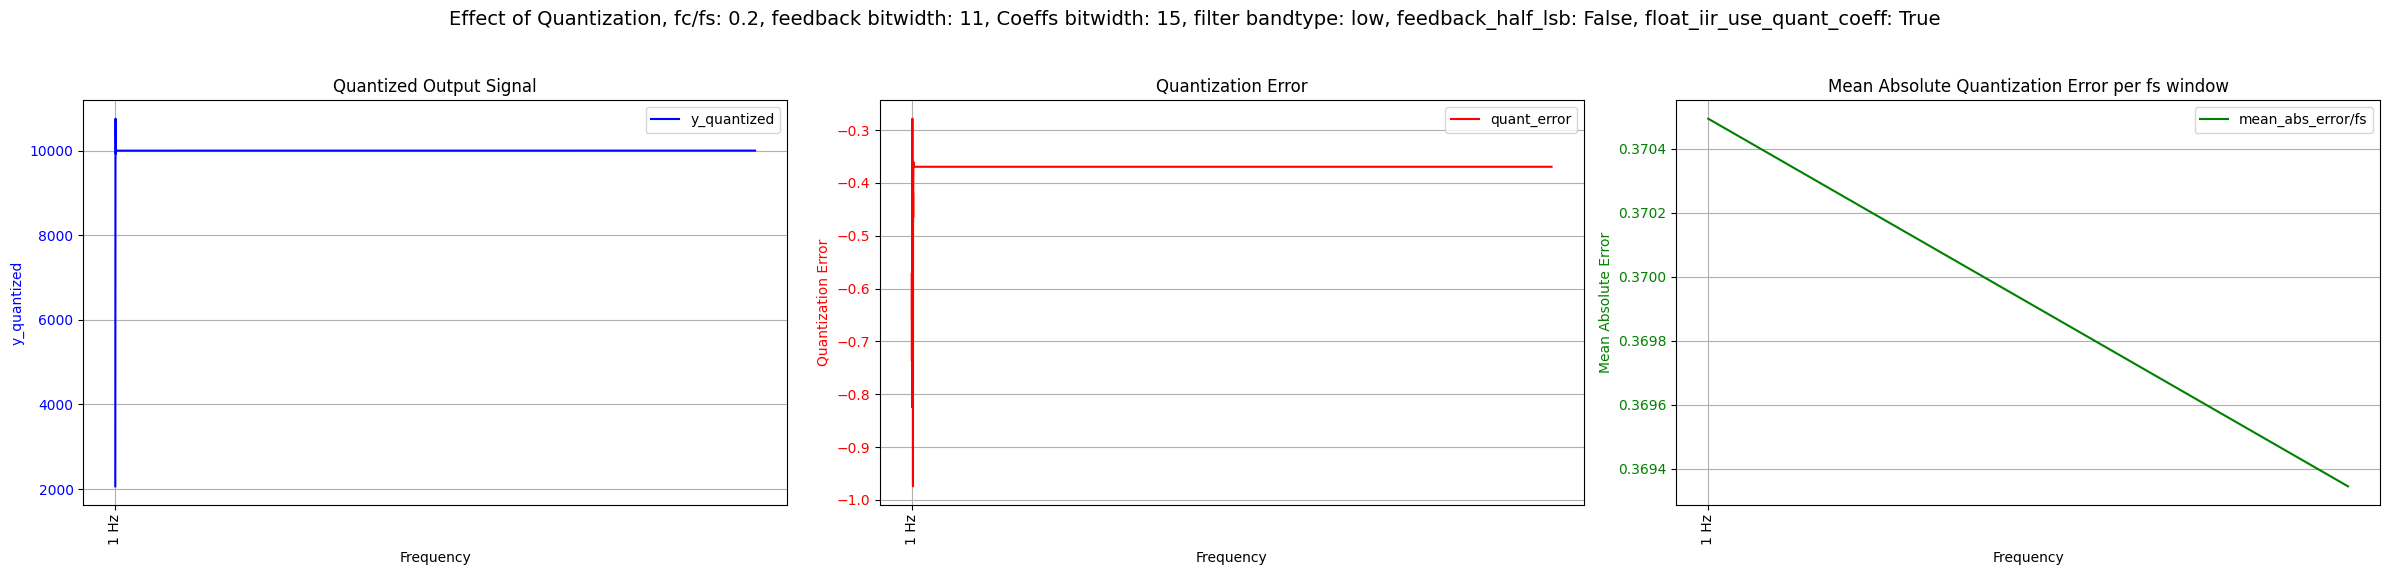

original fc_fs_ratio:  0.22
C模型加载成功!


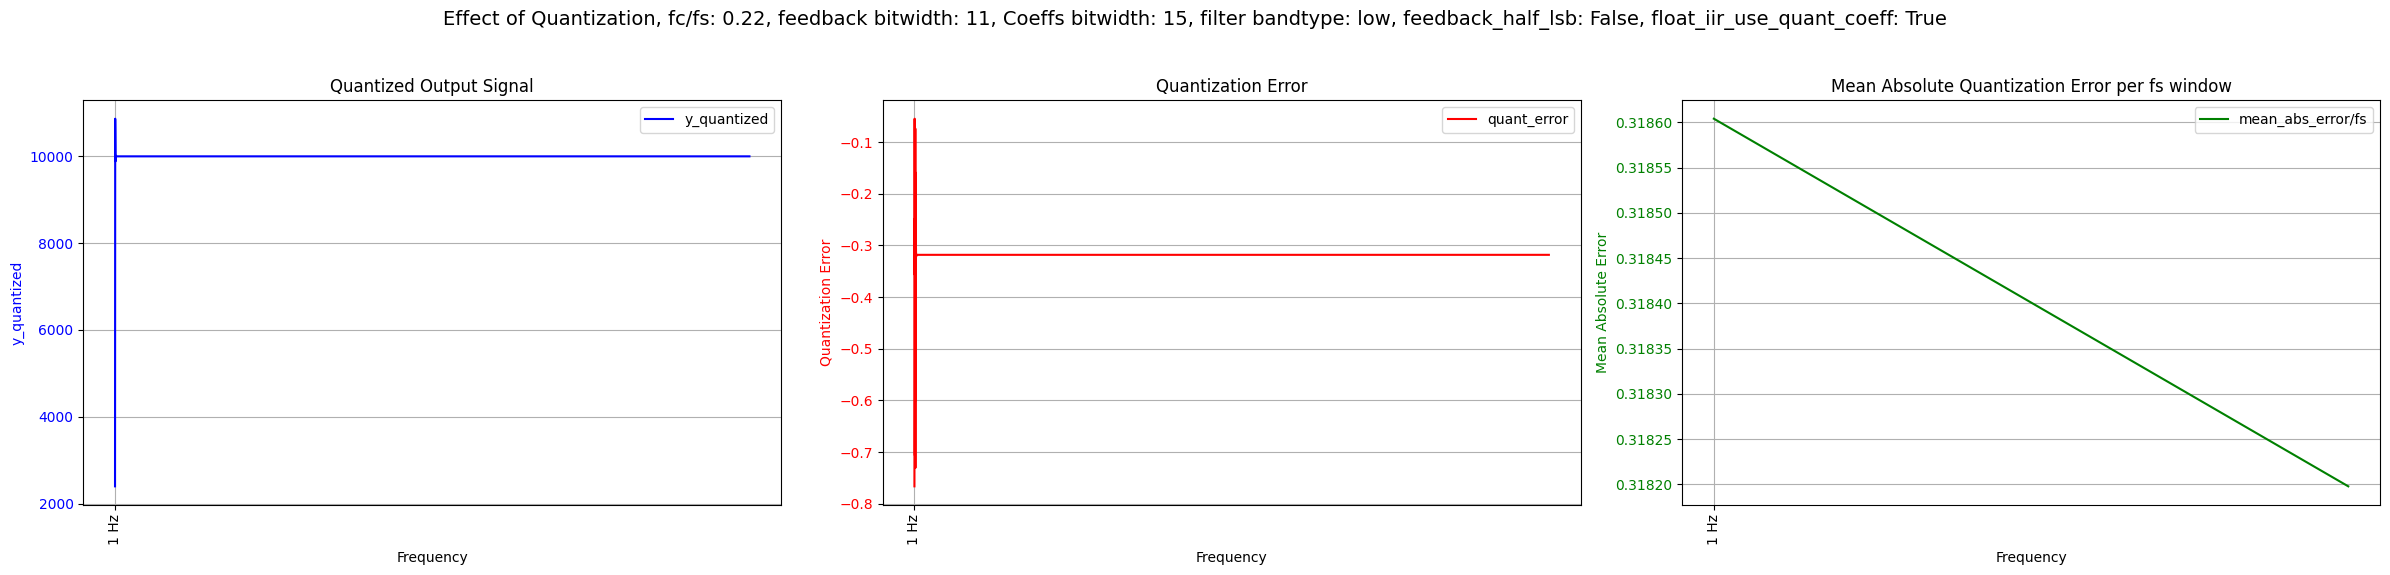

original fc_fs_ratio:  0.24
C模型加载成功!


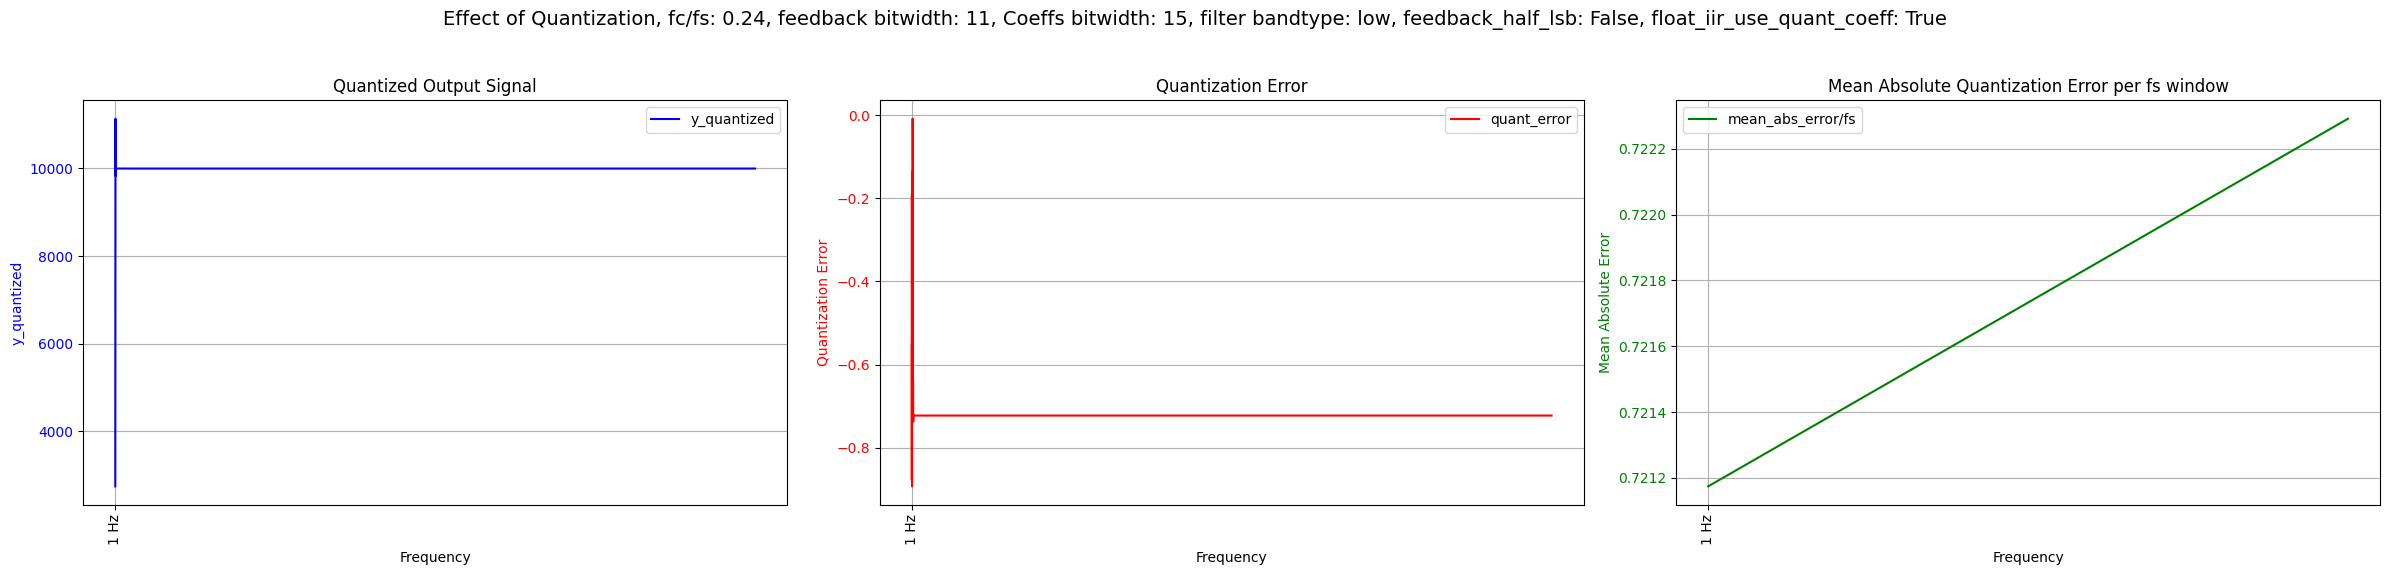

In [10]:
# 直流偏置
btype_lists = ['low'] # ['low', 'high'] # lowpass or highpass filter
fc_fs_ratio_lists = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24] 
iir_coeff_bit_lists = [15]
output_dec_bits_list = [11]
signal_range_list = [0]
feedback_half_lsb_list = [False] # [False, True]  # 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈, 实际测试下来影响不大
float_iir_use_quant_coeff_list = [True] # [True, False]  # 是否使用量化系数来初始化浮点IIR
noise_range = 0
signal_offset = 10000
# signal generator params
# 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 1     # 终止频率
fs = 3200  # 每秒采样点数
time = 2  # 仿真时间

for btype in btype_lists:
    for signal_range in signal_range_list:
        generated_signal = signal_generator(fs, time, signal_range, noise_range, signal_offset, start_freq, end_freq)
        for fc_fs_ratio in fc_fs_ratio_lists:
            for iir_coeff_bit in iir_coeff_bit_lists:
                for output_dec_bits in output_dec_bits_list:
                    for feedback_half_lsb in feedback_half_lsb_list:
                        for float_iir_use_quant_coeff in float_iir_use_quant_coeff_list:
                            # 遍历得到最优的fc_fs
                            # 首先计算原始fc_fs_ratio下的量化误差
                            print("original fc_fs_ratio: ", fc_fs_ratio)
                            initial_quant_error = calc_quant_error(fc_fs_ratio, fs=fs, btype=btype, b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=True)
                            analyze_quantization_error(generated_signal, fc_fs_ratio, iir_coeff_bit, output_dec_bits, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)

                            # # 调用分析函数
                            # # 计算优化后的fc_fs_ratio下的量化误差
                            # fc_fs_ratio = search_best_fc_fs(fc_fs_ratio, iir_coeff_bit, search_range=0.05, fs=fs, signal_range=signal_range)
                            # print("update fc_fs_ratio: ", fc_fs_ratio)
                            # update_quant_error = calc_quant_error(fc_fs_ratio, fs=fs, btype=btype, b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=True)
                            # analyze_quantization_error(generated_signal, fc_fs_ratio, iir_coeff_bit, output_dec_bits, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)

In [11]:
# 随机信号测试，直流偏置 + 白噪声



In [ ]:
# 扫频测试（正弦波扫频测试）:
btype_lists = ['low'] # ['low', 'high'] # lowpass or highpass filter
fc_fs_ratio_lists = [0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24] 
iir_coeff_bit_lists = [15]
output_dec_bits_list = [11]
signal_range_list = [32700]
feedback_half_lsb_list = [False] # [False, True]  # 是否在反馈路径添加0.5 LSB的偏移量以避免负反馈, 实际测试下来影响不大
float_iir_use_quant_coeff_list = [True] # [True, False]  # 是否使用量化系数来初始化浮点IIR
noise_range = 0
signal_offset = 0
# signal generator params
# 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 100     # 终止频率
fs = 3200  # 每秒采样点数
time = 100  # 仿真时间

for btype in btype_lists:
    for signal_range in signal_range_list:
        generated_signal = signal_generator(fs, time, signal_range, noise_range, signal_offset, start_freq, end_freq)
        for fc_fs_ratio in fc_fs_ratio_lists:
            for iir_coeff_bit in iir_coeff_bit_lists:
                for output_dec_bits in output_dec_bits_list:
                    for feedback_half_lsb in feedback_half_lsb_list:
                        for float_iir_use_quant_coeff in float_iir_use_quant_coeff_list:
                            # 遍历得到最优的fc_fs
                            # 首先计算原始fc_fs_ratio下的量化误差
                            print("original fc_fs_ratio: ", fc_fs_ratio)
                            initial_quant_error = calc_quant_error(fc_fs_ratio, fs=fs, btype=btype, b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=True)
                            analyze_quantization_error(generated_signal, fc_fs_ratio, iir_coeff_bit, output_dec_bits, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)

                            # # 调用分析函数
                            # # 计算优化后的fc_fs_ratio下的量化误差
                            # fc_fs_ratio = search_best_fc_fs(fc_fs_ratio, iir_coeff_bit, search_range=0.05, fs=fs, signal_range=signal_range)
                            # print("update fc_fs_ratio: ", fc_fs_ratio)
                            # update_quant_error = calc_quant_error(fc_fs_ratio, fs=fs, btype=btype, b_bit=iir_coeff_bit, a_bit=iir_coeff_bit, signal_range=signal_range, verbose=True)
                            # analyze_quantization_error(generated_signal, fc_fs_ratio, iir_coeff_bit, output_dec_bits, fs=fs, start_freq = start_freq, end_freq = end_freq, signal_range=signal_range, btype=btype, feedback_half_lsb=feedback_half_lsb, float_iir_use_quant_coeff=float_iir_use_quant_coeff)